In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from transformers import BertTokenizer, BertModel
import torch
torch.cuda.is_available()

c:\Users\avsip\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

## Загрузка данных

In [3]:
features_file = r'C:\ML\28_final_task\Online Retail.xlsx'
df = pd.read_excel(features_file)
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

### Пред обработка данных, для исключения пропусков и замены пустых значений

In [4]:
df['Description'].fillna('Прочие', inplace=True)
df['CustomerID'].fillna(-999999, inplace=True)
df['InvoiceNo'].fillna('без номера', inplace=True)
df['Return'] = df['InvoiceNo'].astype(str).str.startswith('C').astype(int)
df['Description'] = df['Description'].str.strip()

df_without_other = df[df['Description'] != 'Прочие']
unique_descriptions = df_without_other[['Description']].drop_duplicates()
unique_descriptions = unique_descriptions.reset_index(drop=True)
print("DataFrame с уникальными товарами:")
unique_descriptions


C:\Users\avsip\AppData\Local\Temp\ipykernel_30568\1594174929.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Description'].fillna('Прочие', inplace=True)
C:\Users\avsip\AppData\Local\Temp\ipykernel_30568\1594174929.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

DataFrame с уникальными товарами:


Description
0      WHITE HANGING HEART T-LIGHT HOLDER
1                     WHITE METAL LANTERN
2          CREAM CUPID HEARTS COAT HANGER
3     KNITTED UNION FLAG HOT WATER BOTTLE
4          RED WOOLLY HOTTIE WHITE HEART.
...                                   ...
4206                      ????damages????
4207                             mixed up
4208                                 lost
4209   CREAM HANGING HEART T-LIGHT HOLDER
4210          PAPER CRAFT , LITTLE BIRDIE

[4211 rows x 1 columns]

In [7]:
len(unique_descriptions)

4211

### Кластеризация товарных позиций с целью выявления категорий товаров для дальнейшего анализа

In [8]:
descriptions = unique_descriptions['Description'].tolist()
unique_descriptions['Description'] = unique_descriptions['Description'].astype(str)


использование модели `paraphrase-MiniLM-L6-v2`

Batches: 100%|██████████| 132/132 [00:00<00:00, 143.20it/s]


Number of clusters: 11


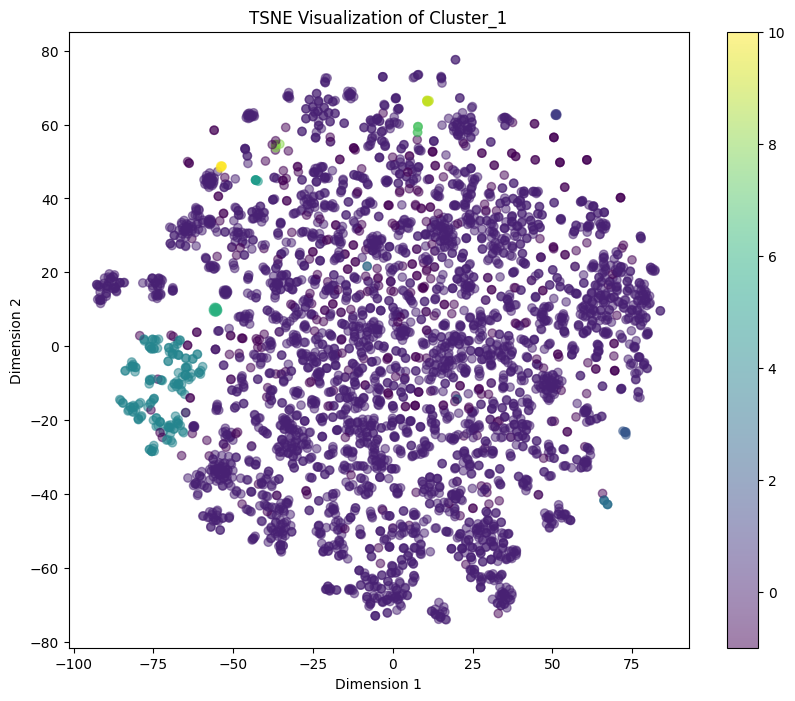

In [251]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('paraphrase-MiniLM-L6-v2', device=device)
embeddings = model.encode(descriptions, show_progress_bar=True, device=device)
scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(embeddings)
tsne = TSNE(n_components=2, random_state=0)
reduced_embeddings = tsne.fit_transform(normalized_embeddings)
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
clusters_1 = dbscan.fit_predict(normalized_embeddings)
num_clusters = len(set(clusters_1)) - (1 if -1 in clusters_1 else 0)
print("Number of clusters:", num_clusters)
unique_descriptions['Cluster_1'] = clusters_1
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters_1, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title('TSNE Visualization of Cluster_1')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [252]:
for cluster_num in set(clusters_1):
    if cluster_num != -1:
        cluster_df = unique_descriptions[unique_descriptions['Cluster_1'] == cluster_num]['Description'].value_counts().head(20)
        print(f"Cluster {cluster_num}:")
        print(cluster_df.index.tolist())
        print("\n")

Cluster 0:
['WHITE HANGING HEART T-LIGHT HOLDER', 'PURPLE VINTAGE EARRINGS', 'SMALL SKULL WINDMILL', 'HOT WATER BOTTLE BABUSHKA LARGE', 'EASTER CRAFT 4 CHICKS', 'BLACK CRYSTAL DROP EARRINGS', 'CRACKED GLAZE EARRINGS BROWN', 'MOP PENDANT SHELL NECKLACE', 'DIAMANTE NECKLACE BLACK', 'Dotcomgiftshop Gift Voucher £40.00', 'WHITE HEART CONFETTI IN TUBE', 'GLASS BEAD HOOP EARRINGS AMETHYST', 'OPIUM SCENTED VOTIVE CANDLE', 'LOVE HEART TRINKET POT', 'ACRYLIC HANGING JEWEL,BLUE', 'GLOW IN DARK DOLPHINS', 'CHEST NATURAL WOOD 20 DRAWERS', 'PINK PAPER PARASOL', 'WHITE BIRD GARDEN DESIGN MUG', 'LARGE ROUND CUTGLASS CANDLESTICK']


Cluster 1:
['POLYESTER FILLER PAD 45x45cm', 'POLYESTER FILLER PAD 45x30cm', 'POLYESTER FILLER PAD 40x40cm', 'POLYESTER FILLER PAD 65CMx65CM', 'POLYESTER FILLER PAD 30CMx30CM', 'POLYESTER FILLER PAD 60x40cm']


Cluster 2:
['HERB MARKER MINT', 'HERB MARKER ROSEMARY', 'HERB MARKER BASIL', 'HERB MARKER CHIVES', 'HERB MARKER PARSLEY', 'HERB MARKER THYME']


Cluster 3:
['BLUE DR

In [253]:
num_clusters = len(set(clusters_1)) - (1 if -1 in clusters_1 else 0)
print(f"Number of clusters: {num_clusters}")

Number of clusters: 11


подбор параметров модели

Batches: 100%|██████████| 132/132 [00:00<00:00, 144.80it/s]


Best parameters: eps=0.2, min_samples=1
Best Silhouette Score: 0.21074555814266205


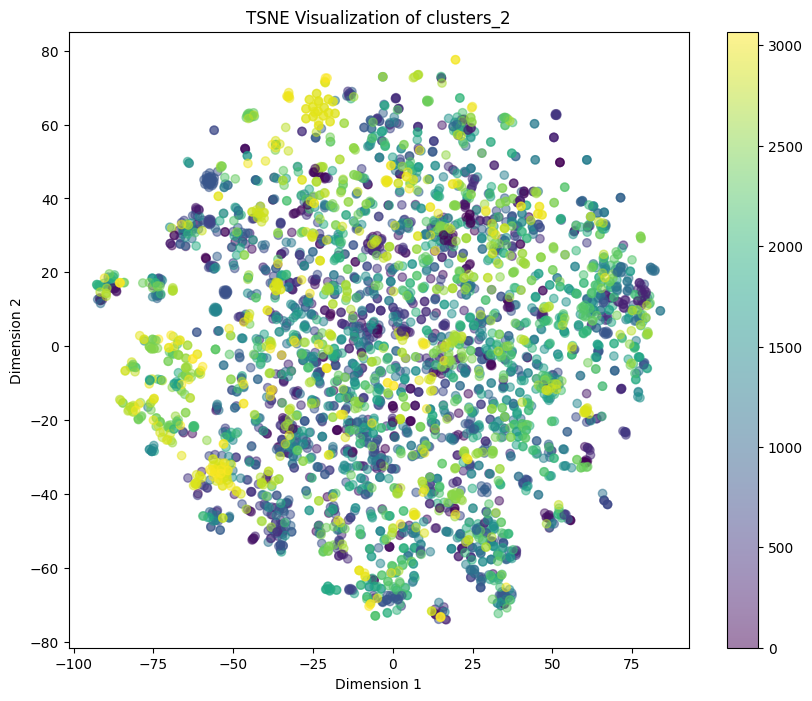

In [254]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('paraphrase-MiniLM-L6-v2', device=device)
embeddings = model.encode(descriptions, show_progress_bar=True, device=device)

scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(embeddings)

tsne = TSNE(n_components=2, random_state=0)
reduced_embeddings = tsne.fit_transform(normalized_embeddings)

eps_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] 
min_samples_values = [1, 2, 3, 4, 5, 6, 7, 8]

best_score = -1
best_params = (None, None)
best_clusters = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        clusters = dbscan.fit_predict(normalized_embeddings)
        if len(set(clusters)) > 1:
            silhouette_avg = silhouette_score(normalized_embeddings, clusters, metric='cosine')
            if silhouette_avg > best_score:
                best_score = silhouette_avg
                best_params = (eps, min_samples)
                best_clusters = clusters

print(f'Best parameters: eps={best_params[0]}, min_samples={best_params[1]}')
print(f'Best Silhouette Score: {best_score}')

dbscan = DBSCAN(eps=best_params[0], min_samples=best_params[1], metric='cosine')
clusters_2 = dbscan.fit_predict(normalized_embeddings)

unique_descriptions['clusters_2'] = clusters
df = df.merge(unique_descriptions[['Description', 'clusters_2']], on='Description', how='left')

plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters_2, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title('TSNE Visualization of clusters_2')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [255]:
len(unique_descriptions)

4210

In [257]:
num_clusters = len(set(clusters_2)) - (1 if -1 in clusters_2 else 0)
print(f"Number of clusters: {num_clusters}")

Number of clusters: 3069


использование разных моделей

Using model: paraphrase-MiniLM-L6-v2


Batches: 100%|██████████| 132/132 [00:00<00:00, 153.74it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.05801863223314285
Testing KMeans with k=3
K=3, Silhouette Score: 0.058912940323352814
Testing KMeans with k=4
K=4, Silhouette Score: 0.06015502288937569
Testing KMeans with k=5
K=5, Silhouette Score: 0.06339877098798752
Testing KMeans with k=6
K=6, Silhouette Score: 0.06645110994577408
Using model: all-MiniLM-L6-v2


Batches: 100%|██████████| 132/132 [00:00<00:00, 138.95it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.05187907814979553
Testing KMeans with k=3
K=3, Silhouette Score: 0.04770687595009804
Testing KMeans with k=4
K=4, Silhouette Score: 0.049637384712696075
Testing KMeans with k=5
K=5, Silhouette Score: 0.051845695823431015
Testing KMeans with k=6
K=6, Silhouette Score: 0.05962826684117317
Using model: bert-base-uncased


No sentence-transformers model found with name bert-base-uncased. Creating a new one with mean pooling.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to 

Testing KMeans with k=2
K=2, Silhouette Score: 0.08130145072937012
Testing KMeans with k=3
K=3, Silhouette Score: 0.07295209169387817
Testing KMeans with k=4
K=4, Silhouette Score: 0.06775904446840286
Testing KMeans with k=5
K=5, Silhouette Score: 0.07064010202884674
Testing KMeans with k=6
K=6, Silhouette Score: 0.07007578760385513
Best model: bert-base-uncased
Best number of clusters (K): 2
Best Silhouette Score: 0.08130145072937012


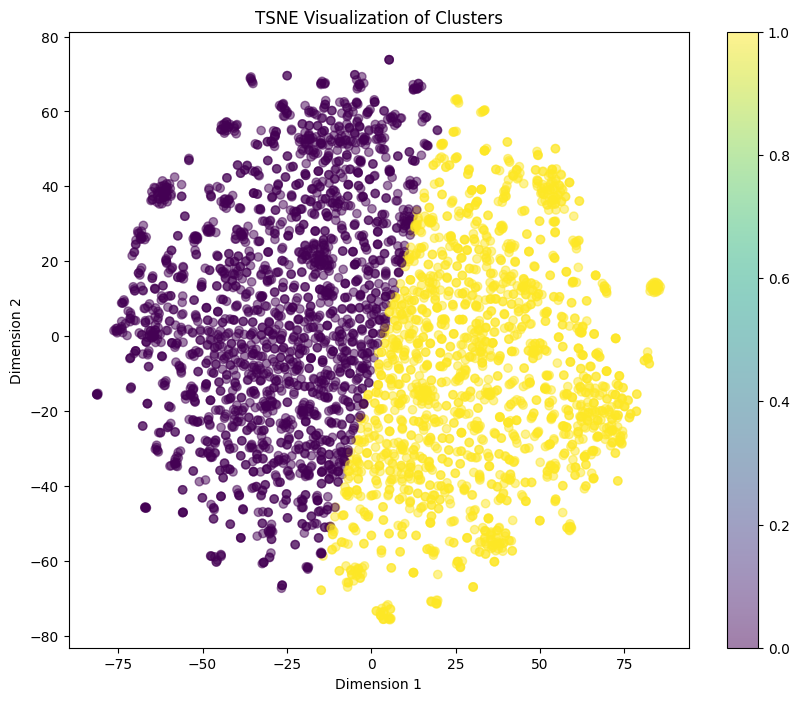

In [258]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Определение моделей для тестирования
models = [
    'paraphrase-MiniLM-L6-v2',
    'all-MiniLM-L6-v2',
    'bert-base-uncased'
]

k_values = [2, 3, 4, 5, 6]

best_score = -1
best_model_name = None
best_k = None
best_clusters = None
best_embeddings = None

for model_name in models:
    print(f"Using model: {model_name}")

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = SentenceTransformer(model_name, device=device)
    embeddings = model.encode(descriptions, show_progress_bar=True, device=device)
    scaler = StandardScaler()
    normalized_embeddings = scaler.fit_transform(embeddings)
    
    tsne = TSNE(n_components=2, random_state=0)
    reduced_embeddings = tsne.fit_transform(normalized_embeddings)
    
    for k in k_values:
        print(f"Testing KMeans with k={k}")

        kmeans = KMeans(n_clusters=k, random_state=0)
        clusters = kmeans.fit_predict(normalized_embeddings)

        silhouette_avg = silhouette_score(normalized_embeddings, clusters, metric='cosine')
        print(f'K={k}, Silhouette Score: {silhouette_avg}')
        
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_model_name = model_name
            best_k = k
            best_clusters = clusters
            best_embeddings = reduced_embeddings

print(f'Best model: {best_model_name}')
print(f'Best number of clusters (K): {best_k}')
print(f'Best Silhouette Score: {best_score}')

kmeans = KMeans(n_clusters=best_k, random_state=0)
clusters_3 = kmeans.fit_predict(best_embeddings)

unique_descriptions['clusters_3'] = clusters

plt.figure(figsize=(10, 8))
scatter = plt.scatter(best_embeddings[:, 0], best_embeddings[:, 1], c=clusters_3, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title('TSNE Visualization of Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [259]:
print(f'Best model: {best_model_name}')
print(f'Best number of clusters (K): {best_k}')
print(f'Best Silhouette Score: {best_score}')

Best model: bert-base-uncased
Best number of clusters (K): 2
Best Silhouette Score: 0.08130145072937012


In [260]:
for cluster_num in set(clusters_3):
    if cluster_num != -1:
        cluster_df = unique_descriptions[unique_descriptions['clusters_3'] == cluster_num]['Description'].value_counts()
        
        top_items = cluster_df.head(10)
        print(f"Cluster {cluster_num}:")
        print(top_items.index.tolist())
        print("\n")

Cluster 0:
['SET 7 BABUSHKA NESTING BOXES', 'RECYCLED ACAPULCO MAT GREEN', 'incorrectly made-thrown away.', 'SET OF 4 PANTRY JELLY MOULDS', 'TRAVEL CARD WALLET TRANSPORT', 'TRAVEL CARD WALLET RETROSPOT', 'TRAVEL CARD WALLET KEEP CALM', 'TRAVEL CARD WALLET RETRO PETALS', 'TRAVEL CARD WALLET SUKI', 'TRAVEL CARD WALLET VINTAGE TICKET']


Cluster 1:
['WHITE METAL LANTERN', 'DOLLCRAFT GIRL AMELIE KIT', 'BOYS PARTY BAG', 'GIRLS PARTY BAG', 'RETRO PILL BOX , REVOLUTIONARY', 'FOLDING SHOE TIDY', 'MADRAS NOTEBOOK MEDIUM', 'PANTRY SCRUBBING BRUSH', 'TRAVEL CARD WALLET PANTRY', 'TRAVEL CARD WALLET SKULLS']




Using model: paraphrase-MiniLM-L6-v2


Batches: 100%|██████████| 132/132 [00:00<00:00, 144.10it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.05801863223314285
K=2, Calinski-Harabasz Score: 128.3477003241944
K=2, Davies-Bouldin Score: 5.596561691059135
Testing KMeans with k=3
K=3, Silhouette Score: 0.058912940323352814
K=3, Calinski-Harabasz Score: 115.77384947775583
K=3, Davies-Bouldin Score: 5.04828669224392
Testing KMeans with k=4
K=4, Silhouette Score: 0.06015502288937569
K=4, Calinski-Harabasz Score: 103.94490636247419
K=4, Davies-Bouldin Score: 4.765374397885086
Testing KMeans with k=5
K=5, Silhouette Score: 0.06339877098798752
K=5, Calinski-Harabasz Score: 96.80408221552476
K=5, Davies-Bouldin Score: 4.761435959464384
Testing KMeans with k=6
K=6, Silhouette Score: 0.06645110994577408
K=6, Calinski-Harabasz Score: 91.84504111802983
K=6, Davies-Bouldin Score: 4.338331019827023
Using model: all-MiniLM-L6-v2


Batches: 100%|██████████| 132/132 [00:00<00:00, 140.38it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.05187907814979553
K=2, Calinski-Harabasz Score: 113.22801777596958
K=2, Davies-Bouldin Score: 5.789846265380892
Testing KMeans with k=3
K=3, Silhouette Score: 0.04770687595009804
K=3, Calinski-Harabasz Score: 92.79937982054878
K=3, Davies-Bouldin Score: 6.001197251999295
Testing KMeans with k=4
K=4, Silhouette Score: 0.049637384712696075
K=4, Calinski-Harabasz Score: 85.044591355984
K=4, Davies-Bouldin Score: 5.4198730757778675
Testing KMeans with k=5
K=5, Silhouette Score: 0.051845695823431015
K=5, Calinski-Harabasz Score: 79.37818660068677
K=5, Davies-Bouldin Score: 5.027101428442696
Testing KMeans with k=6
K=6, Silhouette Score: 0.05962826684117317
K=6, Calinski-Harabasz Score: 77.45677398790771
K=6, Davies-Bouldin Score: 4.774141205160862
Using model: bert-base-uncased


No sentence-transformers model found with name bert-base-uncased. Creating a new one with mean pooling.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to 

Testing KMeans with k=2
K=2, Silhouette Score: 0.08130145072937012
K=2, Calinski-Harabasz Score: 190.3415147496479
K=2, Davies-Bouldin Score: 4.657429118199315
Testing KMeans with k=3
K=3, Silhouette Score: 0.07295209169387817
K=3, Calinski-Harabasz Score: 154.82296054193924
K=3, Davies-Bouldin Score: 4.592057194300371
Testing KMeans with k=4
K=4, Silhouette Score: 0.06775904446840286
K=4, Calinski-Harabasz Score: 128.47221508981613
K=4, Davies-Bouldin Score: 4.523837863431495
Testing KMeans with k=5
K=5, Silhouette Score: 0.07064010202884674
K=5, Calinski-Harabasz Score: 115.68354480198815
K=5, Davies-Bouldin Score: 4.284615433680568
Testing KMeans with k=6
K=6, Silhouette Score: 0.07007578760385513
K=6, Calinski-Harabasz Score: 102.88242197580043
K=6, Davies-Bouldin Score: 4.209589584445742
Best model: bert-base-uncased
Best number of clusters (K): 2
Best Silhouette Score: 0.08130145072937012


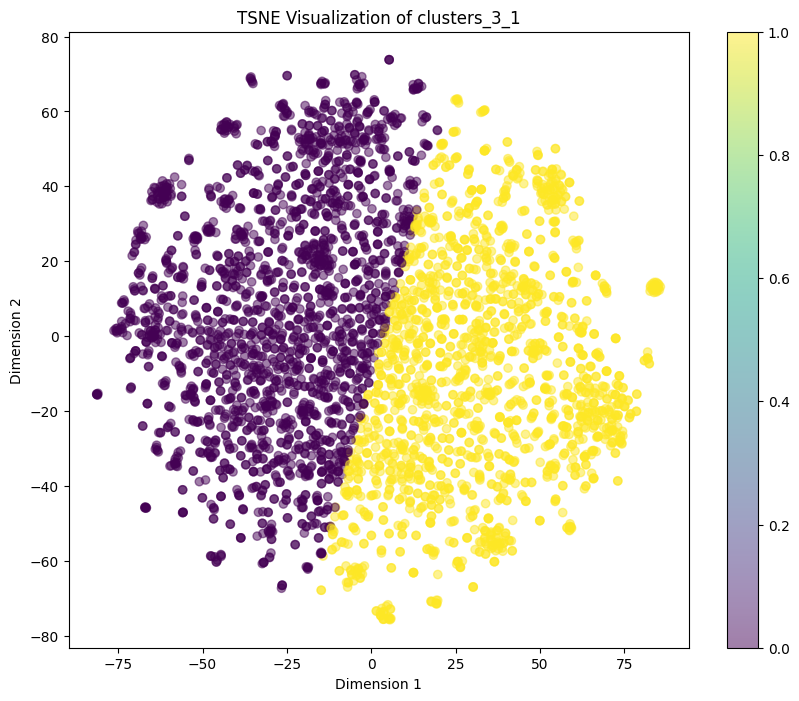

In [261]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

models = [
    'paraphrase-MiniLM-L6-v2',
    'all-MiniLM-L6-v2',
    'bert-base-uncased'
]

k_values = [2, 3, 4, 5, 6]

best_score = -1
best_model_name = None
best_k = None
best_clusters = None
best_embeddings = None

for model_name in models:
    print(f"Using model: {model_name}")

    # Использование SentenceTransformer для получения эмбеддингов
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = SentenceTransformer(model_name, device=device)
    embeddings = model.encode(descriptions, show_progress_bar=True, device=device)
    
    # Нормализация эмбеддингов
    scaler = StandardScaler()
    normalized_embeddings = scaler.fit_transform(embeddings)
    
    # Уменьшение размерности для визуализации
    tsne = TSNE(n_components=2, random_state=0)
    reduced_embeddings = tsne.fit_transform(normalized_embeddings)
    
    for k in k_values:
        print(f"Testing KMeans with k={k}")

        # Кластеризация с использованием KMeans
        kmeans = KMeans(n_clusters=k, random_state=0)
        clusters = kmeans.fit_predict(normalized_embeddings)

        # Расчет метрик качества
        silhouette_avg = silhouette_score(normalized_embeddings, clusters, metric='cosine')
        calinski_harabasz = calinski_harabasz_score(normalized_embeddings, clusters)
        davies_bouldin = davies_bouldin_score(normalized_embeddings, clusters)
        print(f'K={k}, Silhouette Score: {silhouette_avg}')
        print(f'K={k}, Calinski-Harabasz Score: {calinski_harabasz}')
        print(f'K={k}, Davies-Bouldin Score: {davies_bouldin}')
        
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_model_name = model_name
            best_k = k
            best_clusters = clusters
            best_embeddings = reduced_embeddings

print(f'Best model: {best_model_name}')
print(f'Best number of clusters (K): {best_k}')
print(f'Best Silhouette Score: {best_score}')

# Используйте наилучшие параметры для KMeans
kmeans = KMeans(n_clusters=best_k, random_state=0)
clusters_3_1 = kmeans.fit_predict(best_embeddings)

# Добавление результатов кластеризации в DataFrame
unique_descriptions['clusters_3_1'] = clusters_3

# Визуализация кластеров с помощью TSNE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(best_embeddings[:, 0], best_embeddings[:, 1], c=clusters_3_1, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title('TSNE Visualization of clusters_3_1')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [277]:
len(descriptions)

4211

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Поиск оптимальной модели для кластеризации

In [13]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

models = [
    'paraphrase-MiniLM-L6-v2',
    'all-MiniLM-L6-v2',
    'bert-base-uncased',
    'roberta-base',
    'distilbert-base-uncased'
]

k_values = list(range(2, 11))

best_score = -1
best_model_name = None
best_k = None
best_clusters = None
best_embeddings = None

for model_name in models:
    print(f"Using model: {model_name}")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = SentenceTransformer(model_name, device=device)
    print('device', device)
    embeddings = model.encode(descriptions, show_progress_bar=True, device=device)
    
    scaler = StandardScaler()
    normalized_embeddings = scaler.fit_transform(embeddings)
    
    tsne = TSNE(n_components=2, random_state=0)
    reduced_embeddings = tsne.fit_transform(normalized_embeddings)
    
    for k in k_values:
        print(f"Testing KMeans with k={k}")
        kmeans = KMeans(n_clusters=k, random_state=0)
        clusters = kmeans.fit_predict(normalized_embeddings)

        silhouette_avg = silhouette_score(normalized_embeddings, clusters, metric='cosine')
        calinski_harabasz = calinski_harabasz_score(normalized_embeddings, clusters)
        davies_bouldin = davies_bouldin_score(normalized_embeddings, clusters)

        print(f'K={k}, Silhouette Score: {silhouette_avg}, Calinski-Harabasz Score: {calinski_harabasz}, Davies-Bouldin Score: {davies_bouldin}')
        
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_model_name = model_name
            best_k = k
            best_clusters = clusters
            best_embeddings = reduced_embeddings



Using model: paraphrase-MiniLM-L6-v2
device cuda


Batches: 100%|██████████| 132/132 [00:00<00:00, 141.27it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.05730181932449341, Calinski-Harabasz Score: 127.61302237548846, Davies-Bouldin Score: 5.681329094485652
Testing KMeans with k=3
K=3, Silhouette Score: 0.05821828916668892, Calinski-Harabasz Score: 115.09993906677487, Davies-Bouldin Score: 5.101701371572588
Testing KMeans with k=4
K=4, Silhouette Score: 0.059315577149391174, Calinski-Harabasz Score: 103.95850629383276, Davies-Bouldin Score: 4.6869423035701105
Testing KMeans with k=5
K=5, Silhouette Score: 0.062339309602975845, Calinski-Harabasz Score: 98.06663653650226, Davies-Bouldin Score: 4.477896955817593
Testing KMeans with k=6
K=6, Silhouette Score: 0.06720738112926483, Calinski-Harabasz Score: 93.19318062203418, Davies-Bouldin Score: 4.255760615695282
Testing KMeans with k=7
K=7, Silhouette Score: 0.06878934800624847, Calinski-Harabasz Score: 86.7253931533314, Davies-Bouldin Score: 4.226672059438383
Testing KMeans with k=8
K=8, Silhouette Score: 0.07977567613124847, Calinski-Haraba

Batches: 100%|██████████| 132/132 [00:00<00:00, 146.82it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.05201531574130058, Calinski-Harabasz Score: 113.48323494486732, Davies-Bouldin Score: 5.73047382825967
Testing KMeans with k=3
K=3, Silhouette Score: 0.04769632965326309, Calinski-Harabasz Score: 92.83686903248055, Davies-Bouldin Score: 5.989507336660931
Testing KMeans with k=4
K=4, Silhouette Score: 0.05163988471031189, Calinski-Harabasz Score: 85.91145185279967, Davies-Bouldin Score: 5.406957694467184
Testing KMeans with k=5
K=5, Silhouette Score: 0.052044253796339035, Calinski-Harabasz Score: 79.45790480199528, Davies-Bouldin Score: 5.045270708982362
Testing KMeans with k=6
K=6, Silhouette Score: 0.06036924943327904, Calinski-Harabasz Score: 77.55932381204043, Davies-Bouldin Score: 4.760067645852916
Testing KMeans with k=7
K=7, Silhouette Score: 0.06372898072004318, Calinski-Harabasz Score: 72.8581750833134, Davies-Bouldin Score: 4.619891313822572
Testing KMeans with k=8
K=8, Silhouette Score: 0.06297643482685089, Calinski-Harabasz Sc

No sentence-transformers model found with name bert-base-uncased. Creating a new one with mean pooling.


K=10, Silhouette Score: 0.07015237212181091, Calinski-Harabasz Score: 62.759388958532355, Davies-Bouldin Score: 4.288009430046027
Using model: bert-base-uncased


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

device cuda


Batches: 100%|██████████| 132/132 [00:02<00:00, 57.25it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.08139874041080475, Calinski-Harabasz Score: 190.51359438522584, Davies-Bouldin Score: 4.657263371193921
Testing KMeans with k=3
K=3, Silhouette Score: 0.0727706030011177, Calinski-Harabasz Score: 154.96515037652492, Davies-Bouldin Score: 4.5771901816931155
Testing KMeans with k=4
K=4, Silhouette Score: 0.06853809207677841, Calinski-Harabasz Score: 128.74454981242732, Davies-Bouldin Score: 4.469938477144573
Testing KMeans with k=5
K=5, Silhouette Score: 0.06968025863170624, Calinski-Harabasz Score: 115.64320265255652, Davies-Bouldin Score: 4.303353717700373
Testing KMeans with k=6
K=6, Silhouette Score: 0.0704532191157341, Calinski-Harabasz Score: 101.96664912848891, Davies-Bouldin Score: 4.467500638356333
Testing KMeans with k=7
K=7, Silhouette Score: 0.05826900526881218, Calinski-Harabasz Score: 92.48160572736911, Davies-Bouldin Score: 4.407862430117431
Testing KMeans with k=8
K=8, Silhouette Score: 0.07102680206298828, Calinski-Harabas

No sentence-transformers model found with name roberta-base. Creating a new one with mean pooling.


K=10, Silhouette Score: 0.061476048082113266, Calinski-Harabasz Score: 76.88796423357945, Davies-Bouldin Score: 4.060084756263802
Using model: roberta-base


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


device cuda


Batches: 100%|██████████| 132/132 [00:03<00:00, 43.86it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.061607010662555695, Calinski-Harabasz Score: 143.10961881215127, Davies-Bouldin Score: 5.347797339982043
Testing KMeans with k=3
K=3, Silhouette Score: 0.05543811619281769, Calinski-Harabasz Score: 116.40922465160197, Davies-Bouldin Score: 5.214841273853771
Testing KMeans with k=4
K=4, Silhouette Score: 0.05126078426837921, Calinski-Harabasz Score: 134.84578532243623, Davies-Bouldin Score: 4.312428093223862
Testing KMeans with k=5
K=5, Silhouette Score: 0.05197947099804878, Calinski-Harabasz Score: 118.95860820862413, Davies-Bouldin Score: 4.200324704998016
Testing KMeans with k=6
K=6, Silhouette Score: 0.05919533967971802, Calinski-Harabasz Score: 111.52950147344178, Davies-Bouldin Score: 4.191331076480009
Testing KMeans with k=7
K=7, Silhouette Score: 0.05477454513311386, Calinski-Harabasz Score: 98.40687747127066, Davies-Bouldin Score: 4.019417279597395
Testing KMeans with k=8
K=8, Silhouette Score: 0.06450819224119186, Calinski-Harab

No sentence-transformers model found with name distilbert-base-uncased. Creating a new one with mean pooling.


K=10, Silhouette Score: 0.0678623616695404, Calinski-Harabasz Score: 80.2471504264491, Davies-Bouldin Score: 4.158599576817624
Using model: distilbert-base-uncased
device cuda


Batches: 100%|██████████| 132/132 [00:01<00:00, 105.00it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.06691102683544159, Calinski-Harabasz Score: 153.440635766352, Davies-Bouldin Score: 5.176179763269231
Testing KMeans with k=3
K=3, Silhouette Score: 0.06339069455862045, Calinski-Harabasz Score: 133.18622867462864, Davies-Bouldin Score: 4.715553702575606
Testing KMeans with k=4
K=4, Silhouette Score: 0.07323018461465836, Calinski-Harabasz Score: 134.39960760567476, Davies-Bouldin Score: 4.105111970132114
Testing KMeans with k=5
K=5, Silhouette Score: 0.07473518699407578, Calinski-Harabasz Score: 124.03661510873091, Davies-Bouldin Score: 3.9279201990927803
Testing KMeans with k=6
K=6, Silhouette Score: 0.07521216571331024, Calinski-Harabasz Score: 110.63656039768077, Davies-Bouldin Score: 4.099871512828338
Testing KMeans with k=7
K=7, Silhouette Score: 0.07660862803459167, Calinski-Harabasz Score: 103.555733420385, Davies-Bouldin Score: 3.850571123186962
Testing KMeans with k=8
K=8, Silhouette Score: 0.0634571835398674, Calinski-Harabasz 

In [15]:
print(f'Best model: {best_model_name}')
print(f'Best number of clusters (K): {best_k}')
print(f'Best Silhouette Score: {best_score}')


Best model: paraphrase-MiniLM-L6-v2
Best number of clusters (K): 10
Best Silhouette Score: 0.08173604309558868


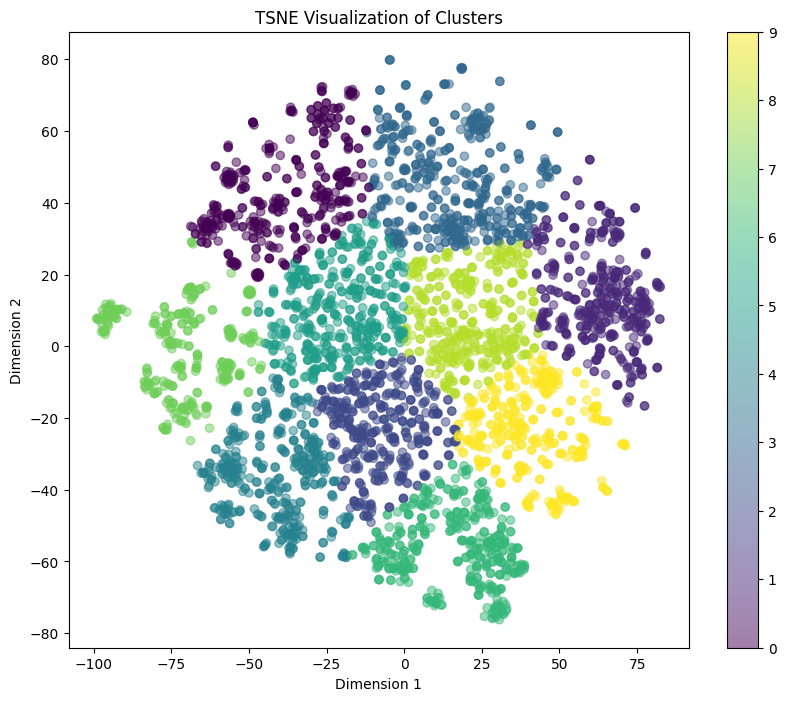

In [22]:

kmeans = KMeans(n_clusters=best_k, random_state=0)
clusters_4 = kmeans.fit_predict(best_embeddings)

unique_descriptions['clusters_4'] = clusters_4

plt.figure(figsize=(10, 8))
scatter = plt.scatter(best_embeddings[:, 0], best_embeddings[:, 1], c=clusters_4, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title('TSNE Visualization of Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [23]:
cluster_distribution = unique_descriptions['clusters_4'].value_counts()
print("Cluster distribution:")
cluster_distribution

Cluster distribution:


clusters_4
3    524
5    461
1    454
6    428
4    424
2    422
0    422
8    411
9    363
7    302
Name: count, dtype: int64

In [24]:
for cluster_num in set(clusters_4):
    if cluster_num != -1:
        cluster_df = unique_descriptions[unique_descriptions['clusters_4'] == cluster_num]['Description'].value_counts()
        
        top_items = cluster_df.head(10)
        print(f"Cluster {cluster_num}:")
        print(top_items.index.tolist())
        print("\n")

Cluster 0:
["POPPY'S PLAYHOUSE BEDROOM", 'CHRISTMAS STAR WISH LIST CHALKBOARD', 'IVORY WIRE KITCHEN ORGANISER', 'ZINC SWEETHEART WIRE LETTER RACK', 'S/2 BEACH HUT TREASURE CHESTS', 'SWEETHEART KEY CABINET', 'mystery! Only ever imported 1800', 'BEACH HUT MIRROR', 'CROCHET WHITE RABBIT KEYRING', 'CROCHET BEAR RED/BLUE  KEYRING']


Cluster 1:
['RED WOOLLY HOTTIE WHITE HEART.', 'CANNABIS LEAF BEAD CURTAIN', 'RESIN BRACELET W PASTEL BEADS', 'TURQUOISE CRYSTAL+GLASS BRACELET', 'GREEN HEART OF GLASS BRACELET', 'TURQUOISE HEART OF GLASS BRACELET', 'METALIC LEAVES BAG CHARMS', 'BLACK 3 BEAD DROP EARRINGS', 'PINK DAISY BAG CHARM', 'RESIN NECKLACE W PASTEL BEADS']


Cluster 2:
['HAND WARMER RED POLKA DOT', 'WRAP DOLLY GIRL', 'SWEETHEART CREAM STEEL TABLE RECT', 'ORANGE TV TRAY TABLE', 'HEN PARTY CORDON BARRIER TAPE', 'BLACK CHRISTMAS FLOCK DROPLET', 'BLUE TILED TRAY', 'JIGSAW TOADSTOOLS 3 PIECE', 'SMALL TALL CAMPHOR WOOD TOADSTOOL', 'DOG BOWL VINTAGE CREAM']


Cluster 3:
['WHITE HANGING HEART T-L

In [25]:
with open('clusters_4_top_20_per_cluster.txt', 'w', encoding='utf-8') as file:
    for cluster_num in set(clusters_4):
        if cluster_num != -1:
            cluster_df = unique_descriptions[unique_descriptions['clusters_4'] == cluster_num]['Description'].value_counts().head(30)
            file.write(f"Cluster {cluster_num}: ")
            file.write('; '.join(cluster_df.index.tolist())) 
            file.write("\n")

### Кластер 0: Декор для дома и аксессуары
- Спальня POPPY'S PLAYHOUSE
- Кухонный органайзер из проволоки цвета слоновой кости
- Зеркало в виде пляжного домика

### Кластер 1: Ювелирные изделия и модные аксессуары
- Красная шерстяная грелка с белым сердцем
- Браслет из бирюзового хрусталя и стекла
- Ожерелье с белыми розами и жемчугом

### Кластер 2: Посуда и кухонные принадлежности
- Квадратный стол из кремовой стали "Sweetheart"
- Набор из 4 красочных мисок для смешивания
- Сковорода в синий горошек

### Кластер 3: Декоративные предметы и подарки
- Белый подвесной держатель для свечей в виде сердца
- Винтажный блокнот "Путешествие"
- Большая розовая фоторамка с драгоценностями

### Кластер 4: Товары для праздников и торжеств
- Винтажная карточная игра "Орёл и решка"
- Средняя стеклянная подставка для торта черного цвета
- Рождественский чулок с падубом

### Кластер 5: Детские игрушки и принадлежности
- Набор 7 матрешек
- Деревянные кегли для сада
- Набор из 4 значков с жуками

### Кластер 6: Праздничный декор и свечи
- Белый металлический фонарь
- Световая цепочка с черными вишнями
- Набор из 3 свечей в виде горшков с растениями

### Кластер 7: Часы и органайзеры
- Будильник розового цвета
- Магнитный список покупок с листьями
- Настенные часы в стиле ретро

### Кластер 8: Сумки и текстиль
- Сумка для обеда в красный горошек
- Сумка с розовыми клубниками
- Кошелек красный с розовым сердцем

### Кластер 9: Игрушки и предметы для детей
- Кукла-принцесса Charlotte из фетра
- Детская садовая вилка синего цвета
- Игрушка-робот Mr. Robot

In [26]:
unique_descriptions

Description  clusters_4
0      WHITE HANGING HEART T-LIGHT HOLDER           3
1                     WHITE METAL LANTERN           6
2          CREAM CUPID HEARTS COAT HANGER           3
3     KNITTED UNION FLAG HOT WATER BOTTLE           3
4          RED WOOLLY HOTTIE WHITE HEART.           1
...                                   ...         ...
4206                      ????damages????           7
4207                             mixed up           7
4208                                 lost           7
4209   CREAM HANGING HEART T-LIGHT HOLDER           3
4210          PAPER CRAFT , LITTLE BIRDIE           6

[4211 rows x 2 columns]

In [27]:
# стоит их как то переименовать по другому чуть более общим логическим понятием

category_name = {
    0: 'Декор для дома и аксессуары',
    1: 'Ювелирные изделия и модные аксессуары',
    2: 'Посуда и кухонные принадлежности',
    3: 'Декоративные предметы и подарки',
    4: 'Товары для праздников и торжеств',
    5: 'Детские игрушки и принадлежности',
    6: 'Праздничный декор и свечи',
    7: 'Часы и органайзеры',
    8: 'Сумки и текстиль',
    9: 'Игрушки и предметы для детейt',
}

In [28]:
unique_descriptions['category_name'] = unique_descriptions.clusters_4.apply(lambda x : category_name.get(x, 'other'))

In [43]:
from googletrans import Translator
translator = Translator()

# Функция для перевода текста
def translate_text(text):
    try:
        return translator.translate(text, dest='ru').text  # Замените 'ru' на нужный язык
    except Exception as e:
        print(f"Ошибка перевода: {e}")
        return text

In [50]:
unique_descriptions

Description  clusters_4  \
0      WHITE HANGING HEART T-LIGHT HOLDER           3   
1                     WHITE METAL LANTERN           6   
2          CREAM CUPID HEARTS COAT HANGER           3   
3     KNITTED UNION FLAG HOT WATER BOTTLE           3   
4          RED WOOLLY HOTTIE WHITE HEART.           1   
...                                   ...         ...   
4206                      ????damages????           7   
4207                             mixed up           7   
4208                                 lost           7   
4209   CREAM HANGING HEART T-LIGHT HOLDER           3   
4210          PAPER CRAFT , LITTLE BIRDIE           6   

                              category_name  
0           Декоративные предметы и подарки  
1                 Праздничный декор и свечи  
2           Декоративные предметы и подарки  
3           Декоративные предметы и подарки  
4     Ювелирные изделия и модные аксессуары  
...                                     ...  
4206                     Часы и органайзеры  
4207                     Часы и органайзеры  
4208                     Часы и органайзеры  
4209        Декоративные предметы и подарки  
4210              Праздничный декор и свечи  

[4211 rows x 3 columns]

перевод 50 товарных позиций для каждой категории для оценки семантического сходства товарных позиций в категориях (25-30% от общего кол. в каждой категории)

In [81]:
unique_descriptions

Description  clusters_4  \
0      WHITE HANGING HEART T-LIGHT HOLDER           3   
1                     WHITE METAL LANTERN           6   
2          CREAM CUPID HEARTS COAT HANGER           3   
3     KNITTED UNION FLAG HOT WATER BOTTLE           3   
4          RED WOOLLY HOTTIE WHITE HEART.           1   
...                                   ...         ...   
4206                      ????damages????           7   
4207                             mixed up           7   
4208                                 lost           7   
4209   CREAM HANGING HEART T-LIGHT HOLDER           3   
4210          PAPER CRAFT , LITTLE BIRDIE           6   

                              category_name  
0           Декоративные предметы и подарки  
1                 Праздничный декор и свечи  
2           Декоративные предметы и подарки  
3           Декоративные предметы и подарки  
4     Ювелирные изделия и модные аксессуары  
...                                     ...  
4206                     Часы и органайзеры  
4207                     Часы и органайзеры  
4208                     Часы и органайзеры  
4209        Декоративные предметы и подарки  
4210              Праздничный декор и свечи  

[4211 rows x 3 columns]

In [83]:
unique_descriptions['translate'] = unique_descriptions.Description.map(lambda x : translate_text(x))

Ошибка перевода: the JSON object must be str, bytes or bytearray, not NoneType


In [84]:
unique_descriptions

Description  clusters_4  \
0      WHITE HANGING HEART T-LIGHT HOLDER           3   
1                     WHITE METAL LANTERN           6   
2          CREAM CUPID HEARTS COAT HANGER           3   
3     KNITTED UNION FLAG HOT WATER BOTTLE           3   
4          RED WOOLLY HOTTIE WHITE HEART.           1   
...                                   ...         ...   
4206                      ????damages????           7   
4207                             mixed up           7   
4208                                 lost           7   
4209   CREAM HANGING HEART T-LIGHT HOLDER           3   
4210          PAPER CRAFT , LITTLE BIRDIE           6   

                              category_name  \
0           Декоративные предметы и подарки   
1                 Праздничный декор и свечи   
2           Декоративные предметы и подарки   
3           Декоративные предметы и подарки   
4     Ювелирные изделия и модные аксессуары   
...                                     ...   
4206                     Часы и органайзеры   
4207                     Часы и органайзеры   
4208                     Часы и органайзеры   
4209        Декоративные предметы и подарки   
4210              Праздничный декор и свечи   

                                       translate  
0       Белый висящий сердечный держатель T-свет  
1                     Белый металлический фонарь  
2                                           Крем  
3     Вязаный флаг союза бутылка с горячей водой  
4       Красное шерстяное красотка белое сердце.  
...                                          ...  
4206                             ???? Ущерб ????  
4207                                   смешанный  
4208                                  потерянный  
4209     Крем-висящий сердечный держатель T-свет  
4210            Бумажное судно, маленькая птичка  

[4211 rows x 4 columns]

In [85]:
unique_descriptions.to_excel('unique_descriptions_category.xlsx')

In [107]:
df_with_category = df.merge(unique_descriptions, how='outer')

In [110]:
df_with_category_wtih_out_other = df_with_category[df_with_category['Description'] != 'Прочие']

In [114]:
df_with_category_wtih_out_other

InvoiceNo StockCode                   Description  Quantity  \
0         538071     21120         *Boombox Ipod Classic       1.0   
1         539437     20954       *USB Office Mirror Ball       1.0   
2         539453     20954       *USB Office Mirror Ball       1.0   
3         536408     22418        10 COLOUR SPACEBOY PEN      24.0   
4         536535     22418        10 COLOUR SPACEBOY PEN      24.0   
...          ...       ...                           ...       ...   
540451    560039     20713  wrongly marked. 23343 in box   -3100.0   
540452    546408     22467  wrongly sold (22719) barcode     170.0   
540453    546018     85172          wrongly sold as sets    -600.0   
540454    546023     85175             wrongly sold sets    -975.0   
541909    572891     23343                           NaN    -400.0   

               InvoiceDate  UnitPrice  CustomerID         Country  Return  \
0      2010-12-09 14:09:00      16.98   -999999.0  United Kingdom     0.0   
1      2010-12-17 14:54:00       8.47   -999999.0  United Kingdom     0.0   
2      2010-12-17 17:08:00       8.47   -999999.0  United Kingdom     0.0   
3      2010-12-01 11:41:00       0.85     14307.0  United Kingdom     0.0   
4      2010-12-01 13:38:00       0.85     15605.0  United Kingdom     0.0   
...                    ...        ...         ...             ...     ...   
540451 2011-07-14 14:27:00       0.00   -999999.0  United Kingdom     0.0   
540452 2011-03-11 16:25:00       0.00   -999999.0  United Kingdom     0.0   
540453 2011-03-08 17:23:00       0.00   -999999.0  United Kingdom     0.0   
540454 2011-03-08 17:29:00       0.00   -999999.0  United Kingdom     0.0   
541909 2011-10-26 14:14:00       0.00   -999999.0  United Kingdom     0.0   

        clusters_4                     category_name  \
0              3.0   Декоративные предметы и подарки   
1              3.0   Декоративные предметы и подарки   
2              3.0   Декоративные предметы и подарки   
3              5.0  Детские игрушки и принадлежности   
4              5.0  Детские игрушки и принадлежности   
...            ...                               ...   
540451         7.0                Часы и органайзеры   
540452         7.0                Часы и органайзеры   
540453         7.0                Часы и органайзеры   
540454         7.0                Часы и органайзеры   
541909         NaN                               NaN   

                                    translate  
0                       *Boombox iPod Classic  
1                     *USB Office Mirror Ball  
2                     *USB Office Mirror Ball  
3                       10 цветовой космосбой  
4                       10 цветовой космосбой  
...                                       ...  
540451    неправильно отмечен.23343 в коробке  
540452  неправильно продан (22719) штрих -код  
540453       ошибочно продается как подставки  
540454           неправильно проданные наборы  
541909                                    NaN  

[540456 rows x 12 columns]

In [150]:
df_with_category_wtih_out_other[df_with_category_wtih_out_other['InvoiceNo'] == 570818]

InvoiceNo StockCode                         Description  Quantity  \
2162      570818     20974         12 PENCILS SMALL TUBE SKULL       2.0   
2587      570818     20983  12 PENCILS TALL TUBE RED RETROSPOT       1.0   
2841      570818     20982         12 PENCILS TALL TUBE SKULLS       1.0   
14235     570818     22077              6 RIBBONS RUSTIC CHARM       2.0   
21544     570818     22726          ALARM CLOCK BAKELIKE GREEN       1.0   
...          ...       ...                                 ...       ...   
525798    570818     21380       WOODEN HAPPY BIRTHDAY GARLAND       1.0   
529446    570818     22579  WOODEN TREE CHRISTMAS SCANDINAVIAN       6.0   
537374    570818     23087          ZINC  HEART T-LIGHT HOLDER       1.0   
538927    570818     84836         ZINC METAL HEART DECORATION       1.0   
538928    570818     84836         ZINC METAL HEART DECORATION       3.0   

               InvoiceDate  UnitPrice  CustomerID         Country  Return  \
2162   2011-10-12 12:47:00       0.65     17841.0  United Kingdom     0.0   
2587   2011-10-12 12:47:00       0.85     17841.0  United Kingdom     0.0   
2841   2011-10-12 12:47:00       0.85     17841.0  United Kingdom     0.0   
14235  2011-10-12 12:47:00       1.95     17841.0  United Kingdom     0.0   
21544  2011-10-12 12:47:00       3.75     17841.0  United Kingdom     0.0   
...                    ...        ...         ...             ...     ...   
525798 2011-10-12 12:47:00       2.95     17841.0  United Kingdom     0.0   
529446 2011-10-12 12:47:00       0.29     17841.0  United Kingdom     0.0   
537374 2011-10-12 12:47:00       1.25     17841.0  United Kingdom     0.0   
538927 2011-10-12 12:47:00       1.25     17841.0  United Kingdom     0.0   
538928 2011-10-12 12:47:00       1.25     17841.0  United Kingdom     0.0   

        clusters_4                     category_name  \
2162           5.0  Детские игрушки и принадлежности   
2587           5.0  Детские игрушки и принадлежности   
2841           5.0  Детские игрушки и принадлежности   
14235          6.0         Праздничный декор и свечи   
21544          7.0                Часы и органайзеры   
...            ...                               ...   
525798         4.0  Товары для праздников и торжеств   
529446         4.0  Товары для праздников и торжеств   
537374         3.0   Декоративные предметы и подарки   
538927         3.0   Декоративные предметы и подарки   
538928         3.0   Декоративные предметы и подарки   

                                             translate  
2162             12 карандашей маленькой трубки черепа  
2587        12 карандашей высокой трубки Red Retrospot  
2841               12 карандашей высокой трубки черепа  
14235                          6 лент деревенский шарм  
21544                                        Будильник  
...                                                ...  
525798           Деревянный с днем ​​рождения Гарленда  
529446  Деревянное дерево рождественское скандинавство  
537374                            Zinc Heart T-Lighter  
538927                          Украшение сердца цинка  
538928                          Украшение сердца цинка  

[133 rows x 12 columns]

In [169]:
df_with_category_wtih_out_other['InvoiceDate'].max(), df_with_category_wtih_out_other['InvoiceDate'].min()

(Timestamp('2011-12-09 12:50:00'), Timestamp('2010-12-01 08:26:00'))

In [177]:
df_with_category_wtih_out_other[df_with_category_wtih_out_other['category_name'] == 'Праздничный декор и свечи']['InvoiceDate'].dt.date.min(), df_with_category_wtih_out_other[df_with_category_wtih_out_other['category_name'] == 'Праздничный декор и свечи']['InvoiceDate'].dt.date.max()

(datetime.date(2010, 12, 1), datetime.date(2011, 12, 9))

In [171]:
df_with_category_wtih_out_other['InvoiceDate'].dt.date

0         2010-12-09
1         2010-12-17
2         2010-12-17
3         2010-12-01
4         2010-12-01
             ...    
540451    2011-07-14
540452    2011-03-11
540453    2011-03-08
540454    2011-03-08
541909    2011-10-26
Name: InvoiceDate, Length: 540456, dtype: object

In [152]:
df_with_category_wtih_out_other.groupby('InvoiceNo').agg({
    'category_name': lambda x : len(list(set(x))),
}).reset_index().sort_values('category_name', ascending=False).head(50).describe()

category_name
count           50.0
mean            10.0
std              0.0
min             10.0
25%             10.0
50%             10.0
75%             10.0
max             10.0

In [155]:
import holidays
# Создаем столбец с днем недели
df_with_category_wtih_out_other['День недели'] = df_with_category_wtih_out_other['InvoiceDate'].dt.day_name()

# Создаем столбец с признаком праздника
us_holidays = holidays.US()
df_with_category_wtih_out_other['Праздник'] = df_with_category_wtih_out_other['InvoiceDate'].dt.date.isin(us_holidays)

# Создаем столбец с датой
df_with_category_wtih_out_other['Дата'] = df_with_category_wtih_out_other['InvoiceDate'].dt.date

# Создаем столбец с неделей в году
df_with_category_wtih_out_other['Неделя в году'] = df_with_category_wtih_out_other['InvoiceDate'].dt.isocalendar().week

# Оставляем только год из даты
df_with_category_wtih_out_other['Год'] = df_with_category_wtih_out_other['InvoiceDate'].dt.year

C:\Users\avsip\AppData\Local\Temp\ipykernel_30568\312703071.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_category_wtih_out_other['День недели'] = df_with_category_wtih_out_other['InvoiceDate'].dt.day_name()
C:\Users\avsip\AppData\Local\Temp\ipykernel_30568\312703071.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_category_wtih_out_other['Праздник'] = df_with_category_wtih_out_other['InvoiceDate'].dt.date.isin(us_holidays)
C:\Users\avsip\AppData\Local\Temp\ipykernel_30568\312703071

In [158]:
import seaborn as sns

In [227]:
# Группируем данные по дате и кластеру, считаем сумму продаж
import matplotlib.dates as mdates

def show_graf(cat_name):
    sales_by_date_cluster = df_with_category_wtih_out_other[
        (df_with_category_wtih_out_other['category_name'] == cat_name) & 
        (df_with_category_wtih_out_other['Quantity'] > 0)
    ].groupby(['Дата', 'category_name'])['Quantity'].sum().reset_index()

    # Создаем фигуру и оси
    fig, ax = plt.subplots(figsize=(24, 6))

    # Строим график сезонности продаж по дате и кластеру
    sns.lineplot(x='Дата', y='Quantity', hue='category_name', data=sales_by_date_cluster, ax=ax)

    # Настраиваем оформление графика
    d_start, d_end = sales_by_date_cluster['Дата'].min(), sales_by_date_cluster['Дата'].max()
    ax.set_title(f'Сезонность продаж по дате и {cat_name} c {d_start} по {d_end}')
    ax.set_xlabel('Дата')
    ax.set_ylabel('Продажи')
    
    # Настройка даты на оси X
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Формат даты

    ax.tick_params(axis='x', rotation=90)
    plt.tight_layout()
    plt.show()


def show_graf_remove(cat_name):
    sales_by_date_cluster = df_with_category_wtih_out_other[
        (df_with_category_wtih_out_other['category_name'] == cat_name) & 
        (df_with_category_wtih_out_other['Quantity'] <= 0)
    ].groupby(['Дата', 'category_name'])['Quantity'].sum().reset_index()

    # Создаем фигуру и оси
    fig, ax = plt.subplots(figsize=(24, 6))

    # Строим график сезонности продаж по дате и кластеру
    sns.lineplot(x='Дата', y='Quantity', hue='category_name', data=sales_by_date_cluster, ax=ax, palette=sns.color_palette("husl", 9))

    # Настраиваем оформление графика
    d_start, d_end = sales_by_date_cluster['Дата'].min(), sales_by_date_cluster['Дата'].max()
    ax.set_title(f'Сезонность возвратов по дате и {cat_name} c {d_start} по {d_end}')
    ax.set_xlabel('Дата')
    ax.set_ylabel('Продажи')
    
    # Настройка даты на оси X
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Формат даты

    ax.tick_params(axis='x', rotation=90)
    plt.tight_layout()
    plt.show()

In [225]:
df_with_category_wtih_out_other

InvoiceNo StockCode                   Description  Quantity  \
0         538071     21120         *Boombox Ipod Classic       1.0   
1         539437     20954       *USB Office Mirror Ball       1.0   
2         539453     20954       *USB Office Mirror Ball       1.0   
3         536408     22418        10 COLOUR SPACEBOY PEN      24.0   
4         536535     22418        10 COLOUR SPACEBOY PEN      24.0   
...          ...       ...                           ...       ...   
540451    560039     20713  wrongly marked. 23343 in box   -3100.0   
540452    546408     22467  wrongly sold (22719) barcode     170.0   
540453    546018     85172          wrongly sold as sets    -600.0   
540454    546023     85175             wrongly sold sets    -975.0   
541909    572891     23343                           NaN    -400.0   

               InvoiceDate  UnitPrice  CustomerID         Country  Return  \
0      2010-12-09 14:09:00      16.98   -999999.0  United Kingdom     0.0   
1      2010-12-17 14:54:00       8.47   -999999.0  United Kingdom     0.0   
2      2010-12-17 17:08:00       8.47   -999999.0  United Kingdom     0.0   
3      2010-12-01 11:41:00       0.85     14307.0  United Kingdom     0.0   
4      2010-12-01 13:38:00       0.85     15605.0  United Kingdom     0.0   
...                    ...        ...         ...             ...     ...   
540451 2011-07-14 14:27:00       0.00   -999999.0  United Kingdom     0.0   
540452 2011-03-11 16:25:00       0.00   -999999.0  United Kingdom     0.0   
540453 2011-03-08 17:23:00       0.00   -999999.0  United Kingdom     0.0   
540454 2011-03-08 17:29:00       0.00   -999999.0  United Kingdom     0.0   
541909 2011-10-26 14:14:00       0.00   -999999.0  United Kingdom     0.0   

        clusters_4                     category_name  \
0              3.0   Декоративные предметы и подарки   
1              3.0   Декоративные предметы и подарки   
2              3.0   Декоративные предметы и подарки   
3              5.0  Детские игрушки и принадлежности   
4              5.0  Детские игрушки и принадлежности   
...            ...                               ...   
540451         7.0                Часы и органайзеры   
540452         7.0                Часы и органайзеры   
540453         7.0                Часы и органайзеры   
540454         7.0                Часы и органайзеры   
541909         NaN                               NaN   

                                    translate День недели  Праздник  \
0                       *Boombox iPod Classic    Thursday     False   
1                     *USB Office Mirror Ball      Friday     False   
2                     *USB Office Mirror Ball      Friday     False   
3                       10 цветовой космосбой   Wednesday     False   
4                       10 цветовой космосбой   Wednesday     False   
...                                       ...         ...       ...   
540451    неправильно отмечен.23343 в коробке    Thursday     False   
540452  неправильно продан (22719) штрих -код      Friday     False   
540453       ошибочно продается как подставки     Tuesday     False   
540454           неправильно проданные наборы     Tuesday     False   
541909                                    NaN   Wednesday     False   

              Дата  Неделя в году     Год  
0       2010-12-09             49  2010.0  
1       2010-12-17             50  2010.0  
2       2010-12-17             50  2010.0  
3       2010-12-01             48  2010.0  
4       2010-12-01             48  2010.0  
...            ...            ...     ...  
540451  2011-07-14             28  2011.0  
540452  2011-03-11             10  2011.0  
540453  2011-03-08             10  2011.0  
540454  2011-03-08             10  2011.0  
541909  2011-10-26             43  2011.0  

[540456 rows x 17 columns]

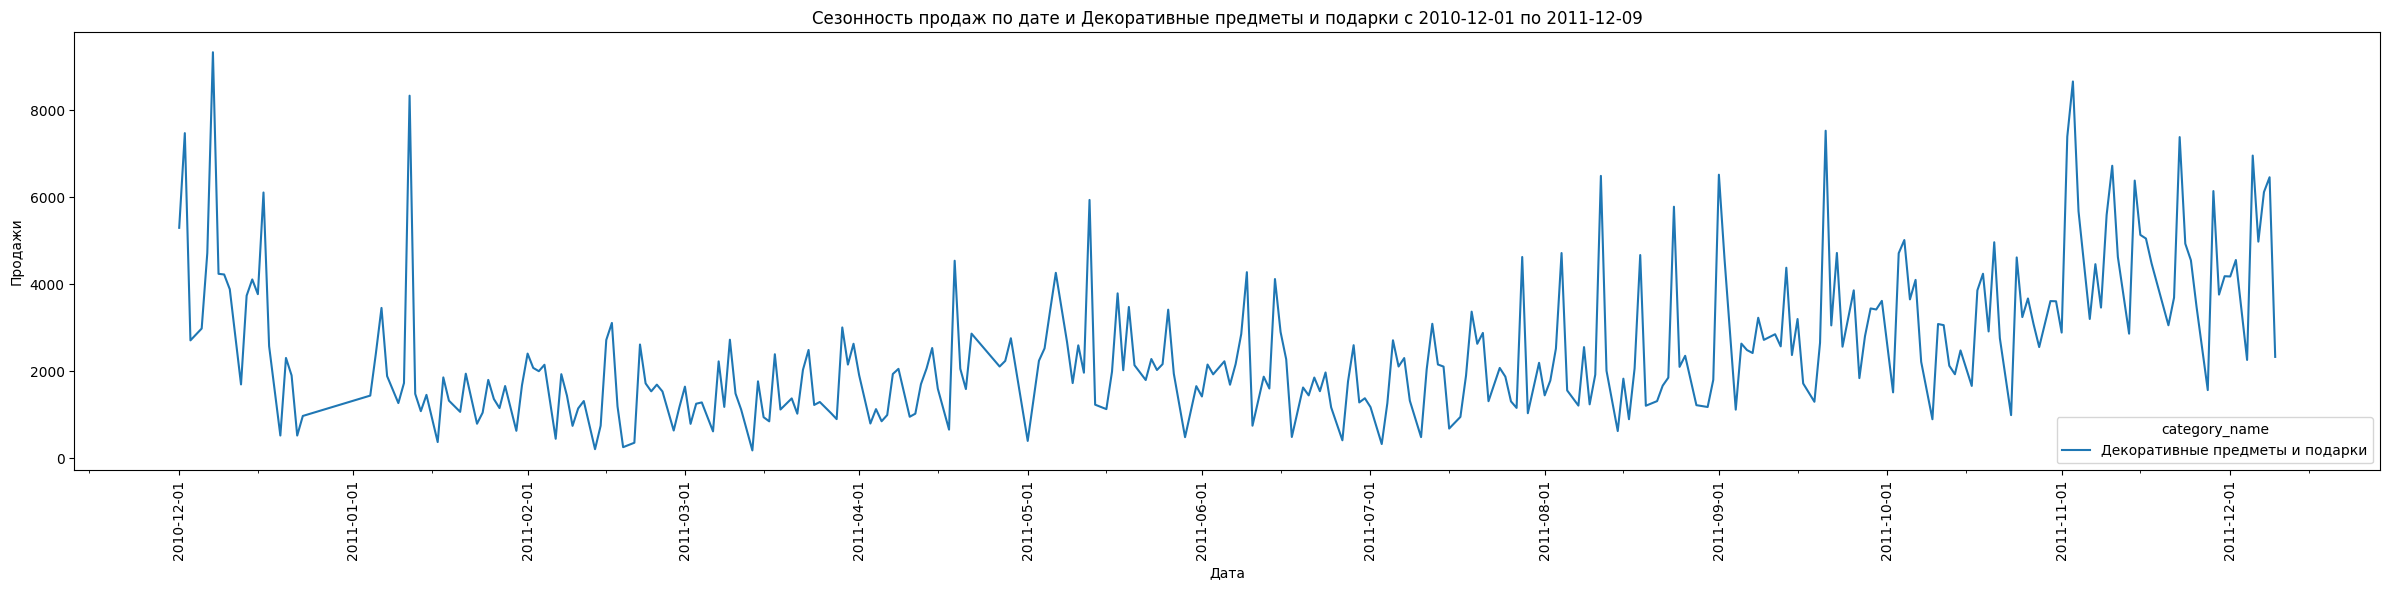

C:\Users\avsip\AppData\Local\Temp\ipykernel_30568\2817455719.py:42: UserWarning: The palette list has more values (9) than needed (1), which may not be intended.
  sns.lineplot(x='Дата', y='Quantity', hue='category_name', data=sales_by_date_cluster, ax=ax, palette=sns.color_palette("husl", 9))


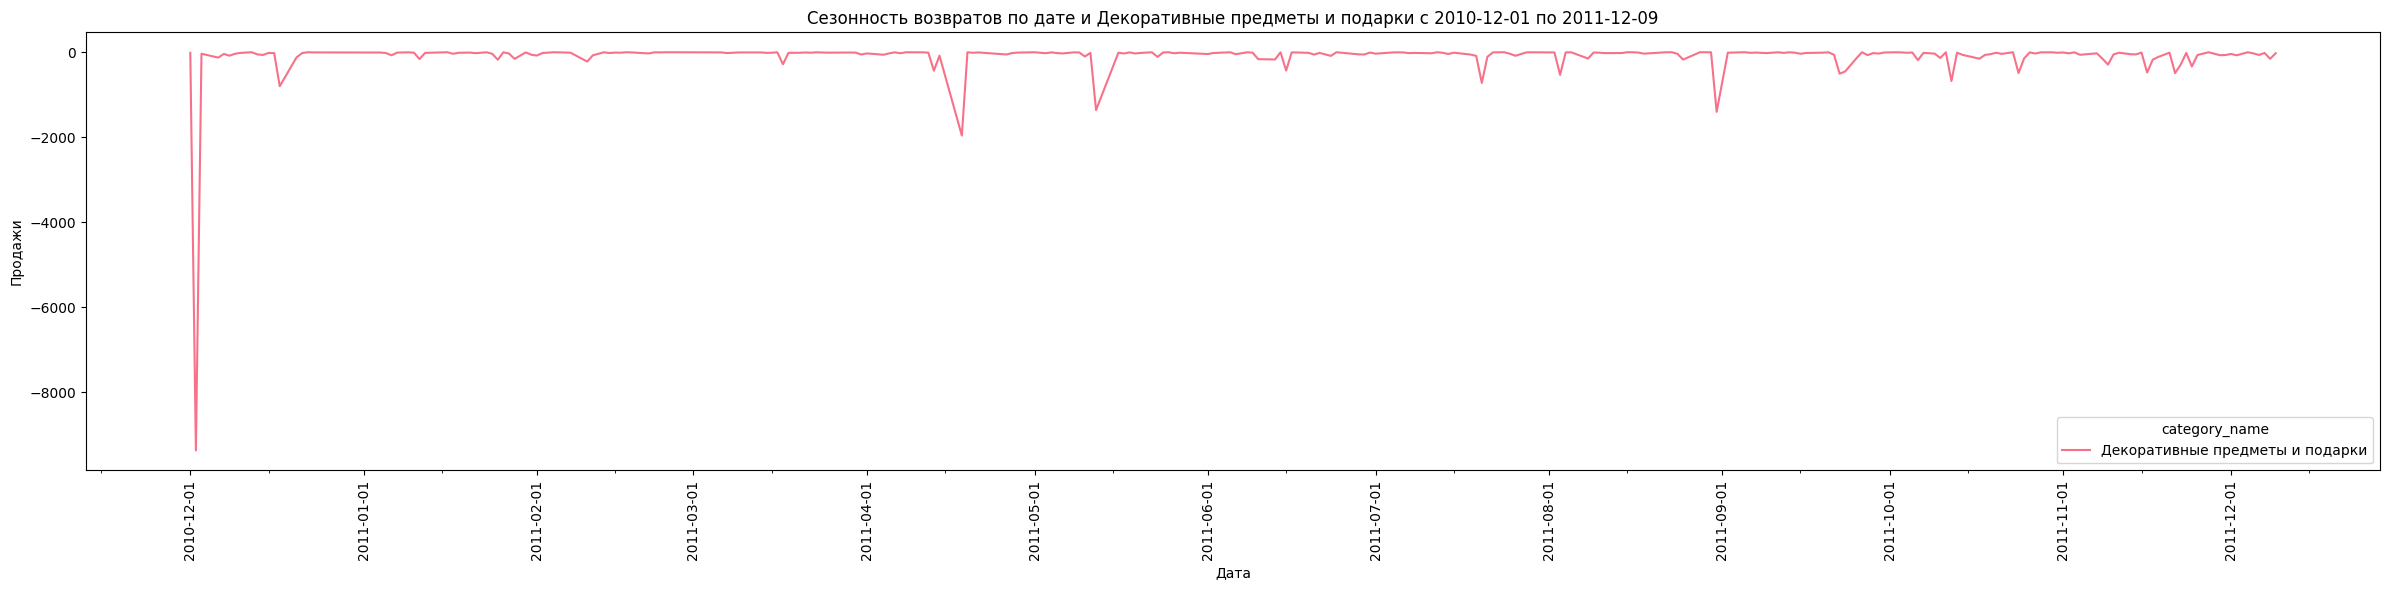

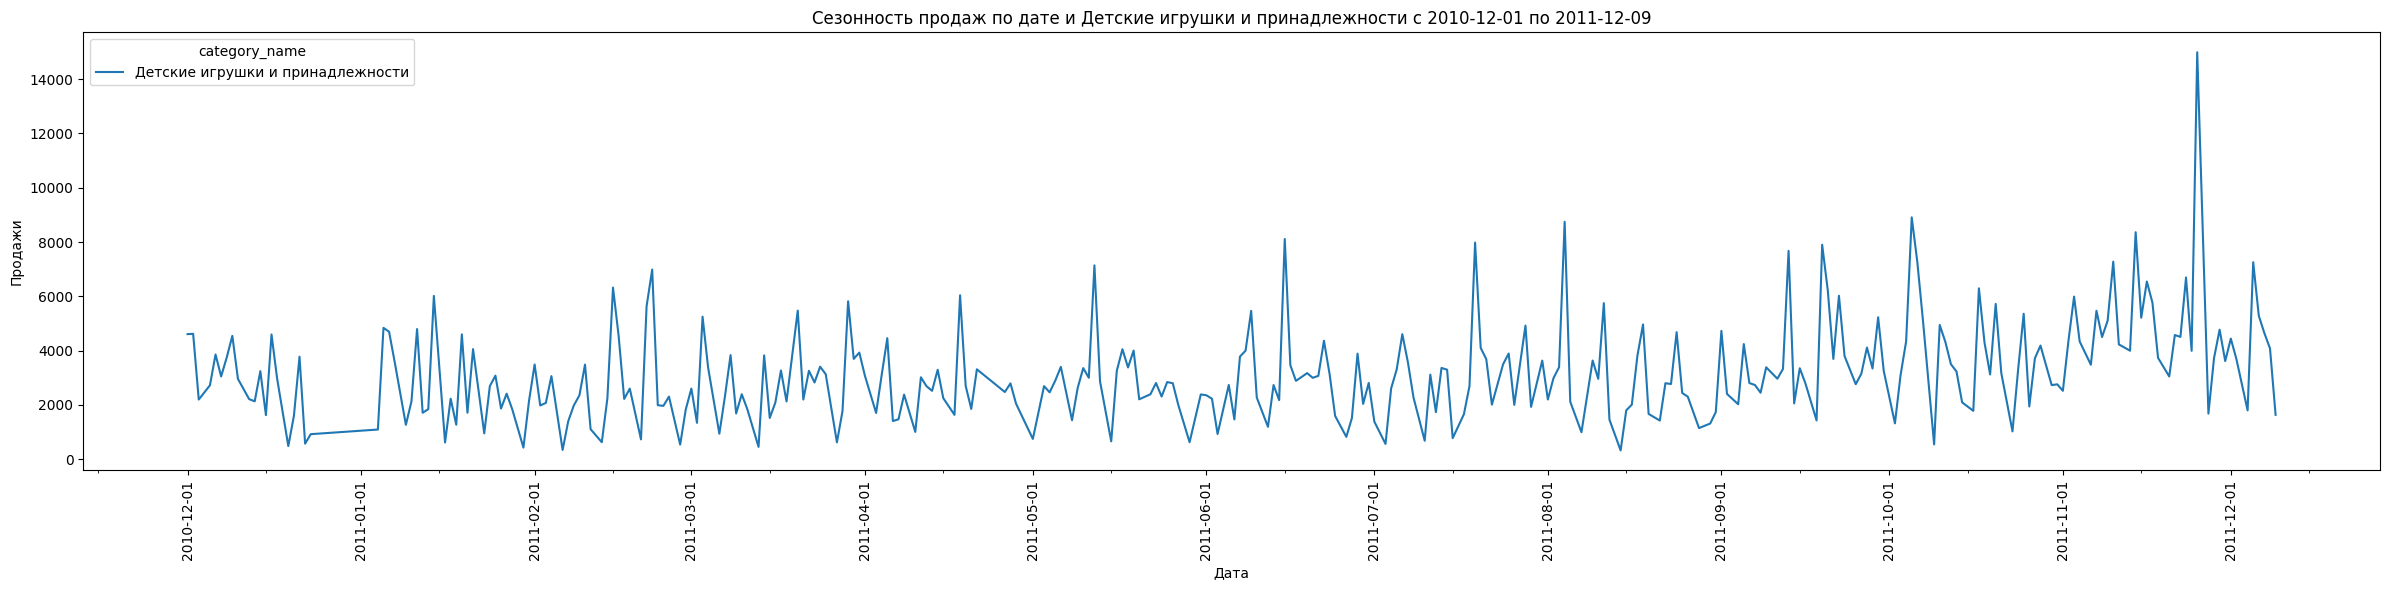

C:\Users\avsip\AppData\Local\Temp\ipykernel_30568\2817455719.py:42: UserWarning: The palette list has more values (9) than needed (1), which may not be intended.
  sns.lineplot(x='Дата', y='Quantity', hue='category_name', data=sales_by_date_cluster, ax=ax, palette=sns.color_palette("husl", 9))


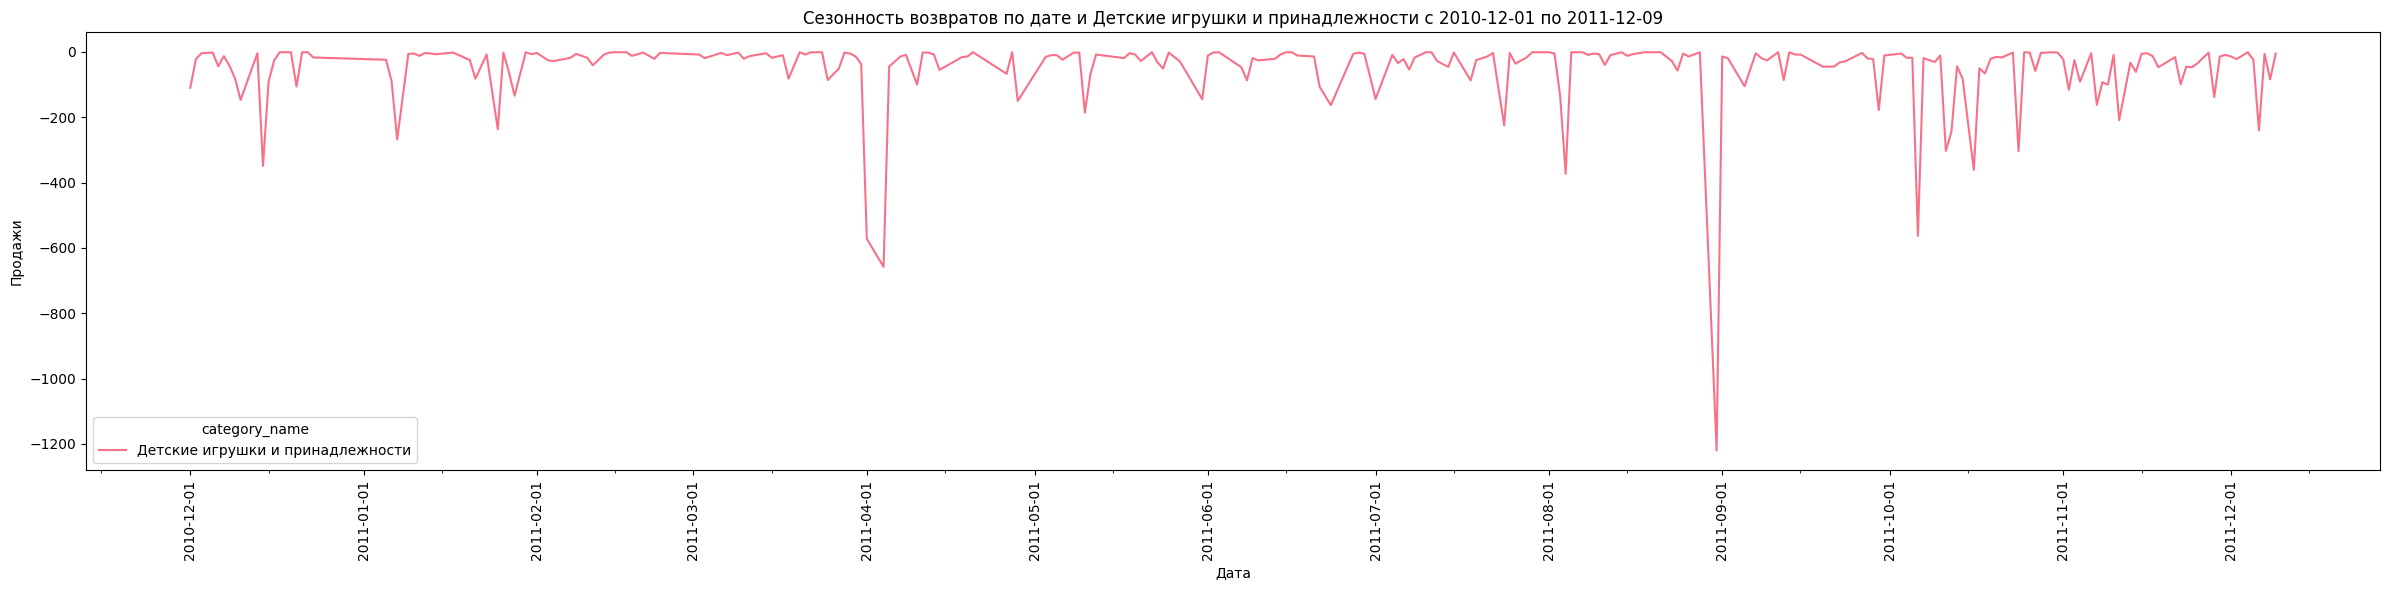

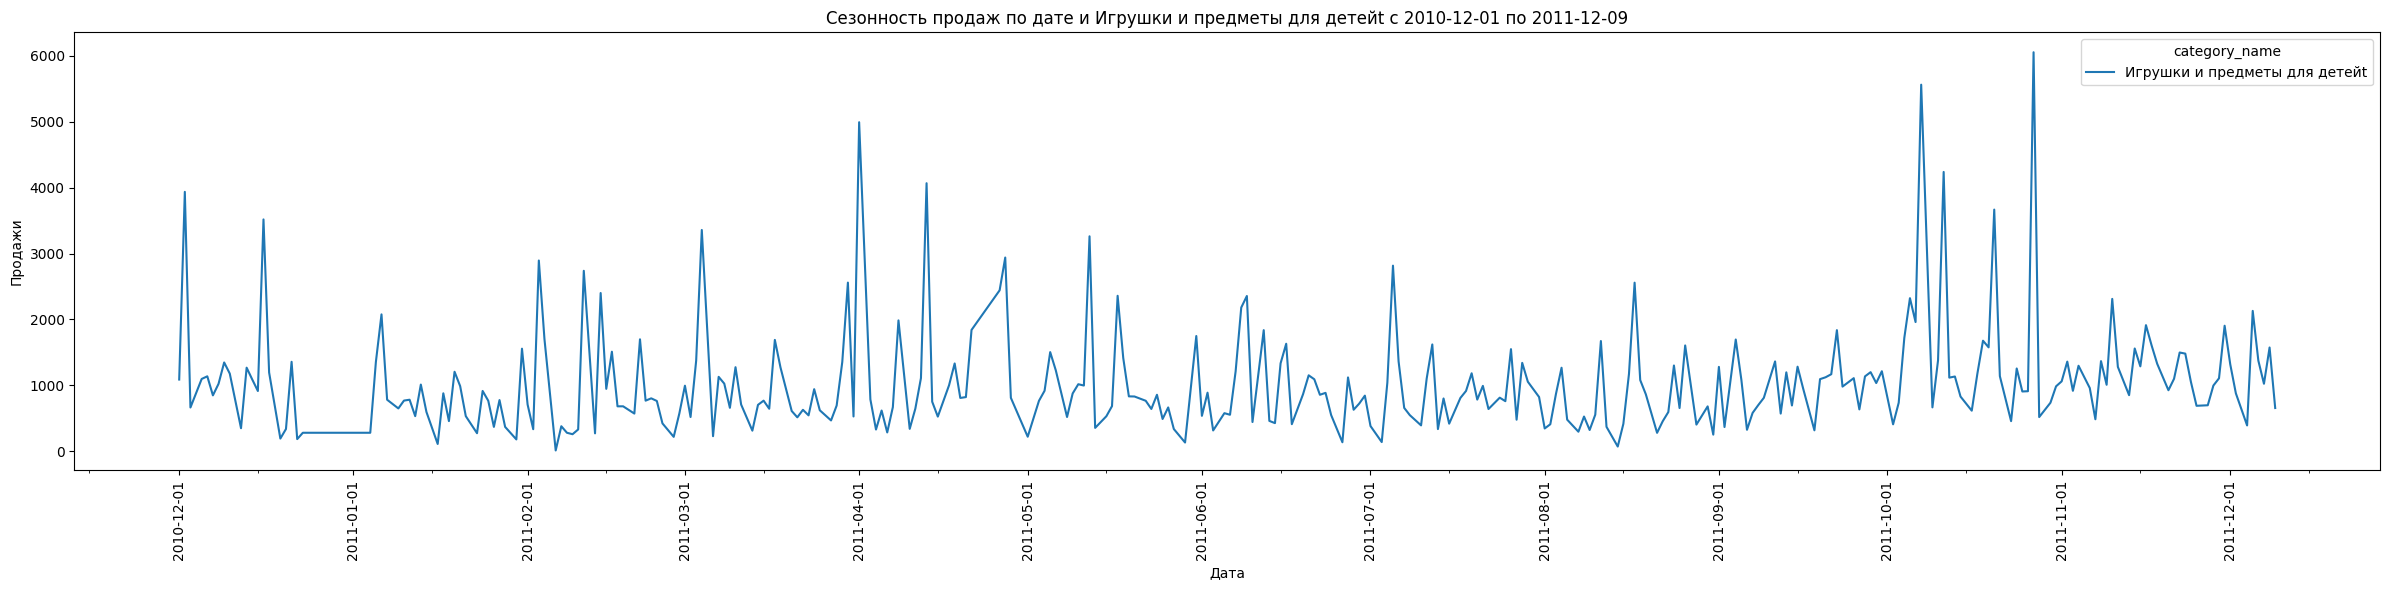

C:\Users\avsip\AppData\Local\Temp\ipykernel_30568\2817455719.py:42: UserWarning: The palette list has more values (9) than needed (1), which may not be intended.
  sns.lineplot(x='Дата', y='Quantity', hue='category_name', data=sales_by_date_cluster, ax=ax, palette=sns.color_palette("husl", 9))


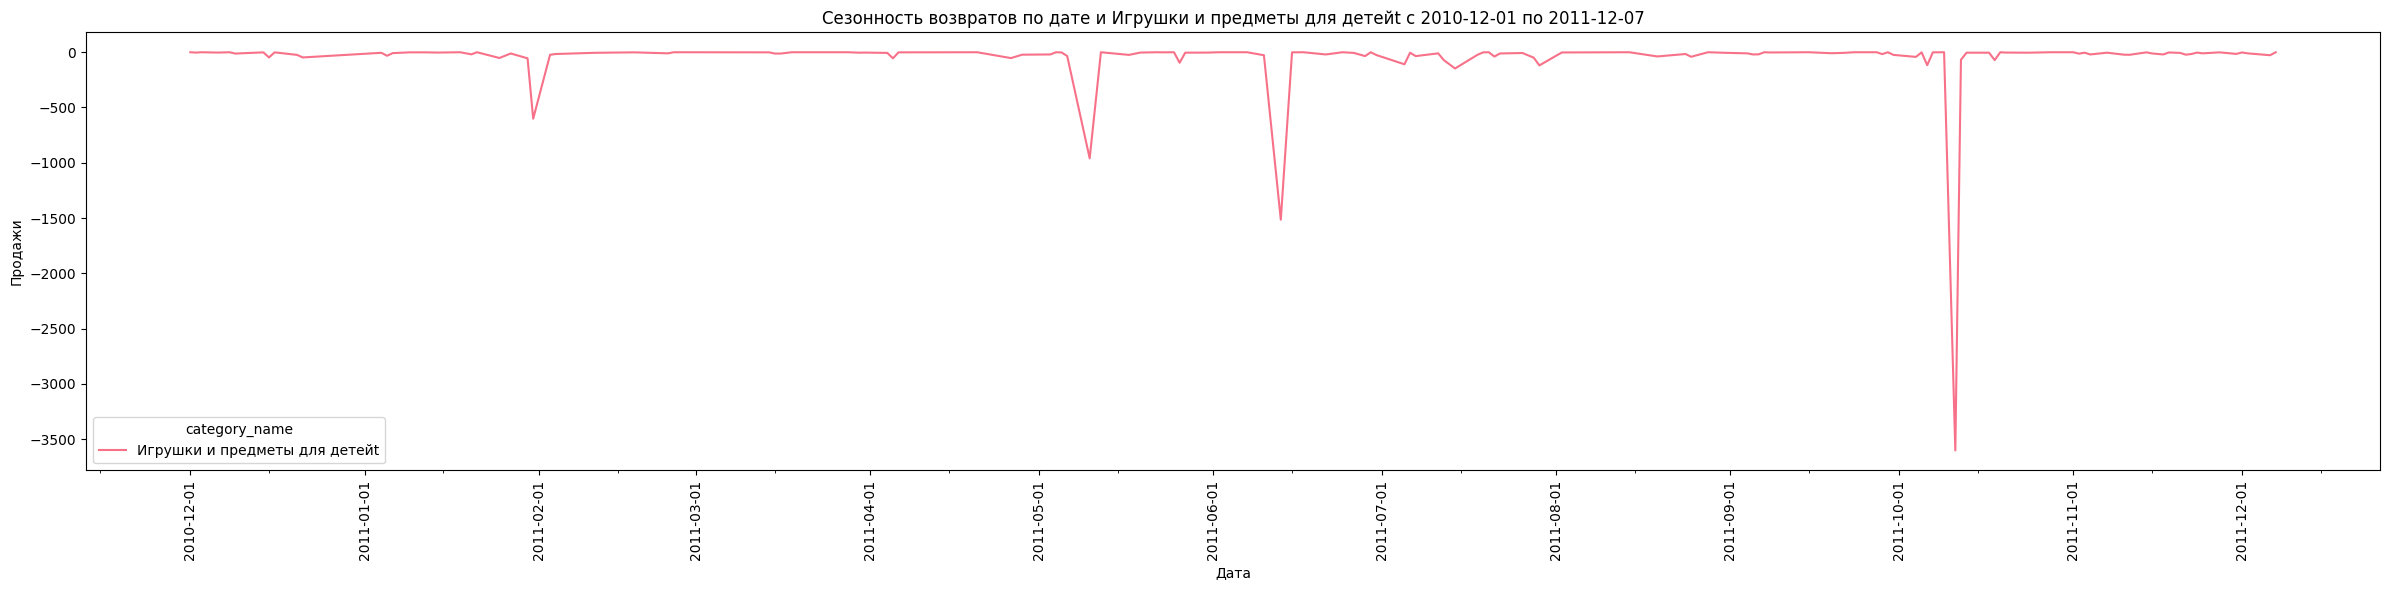

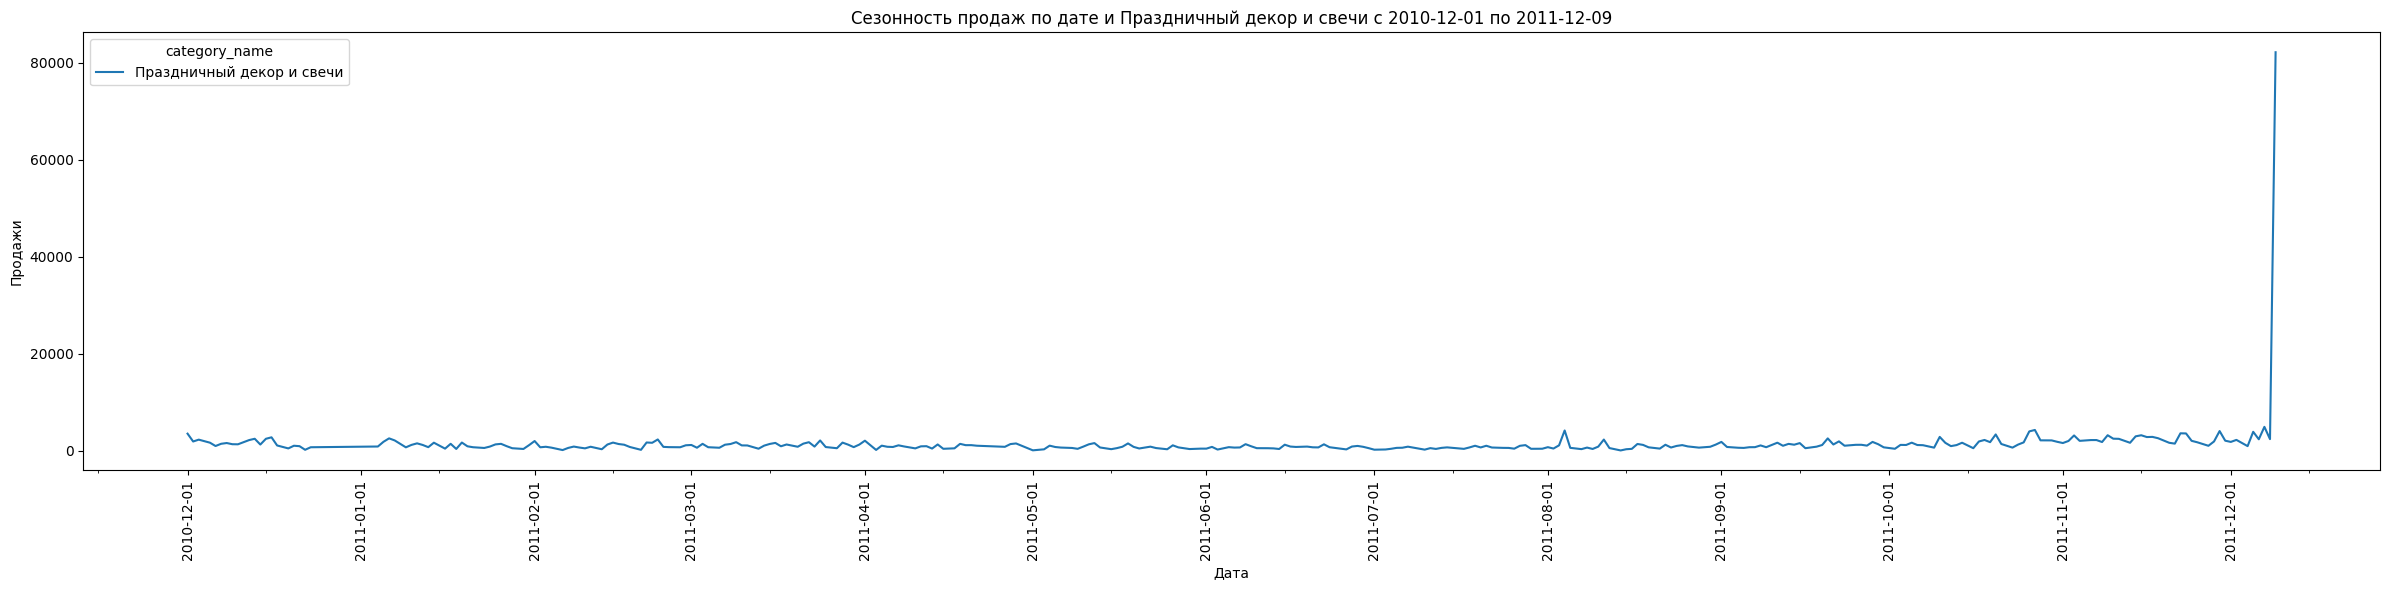

C:\Users\avsip\AppData\Local\Temp\ipykernel_30568\2817455719.py:42: UserWarning: The palette list has more values (9) than needed (1), which may not be intended.
  sns.lineplot(x='Дата', y='Quantity', hue='category_name', data=sales_by_date_cluster, ax=ax, palette=sns.color_palette("husl", 9))


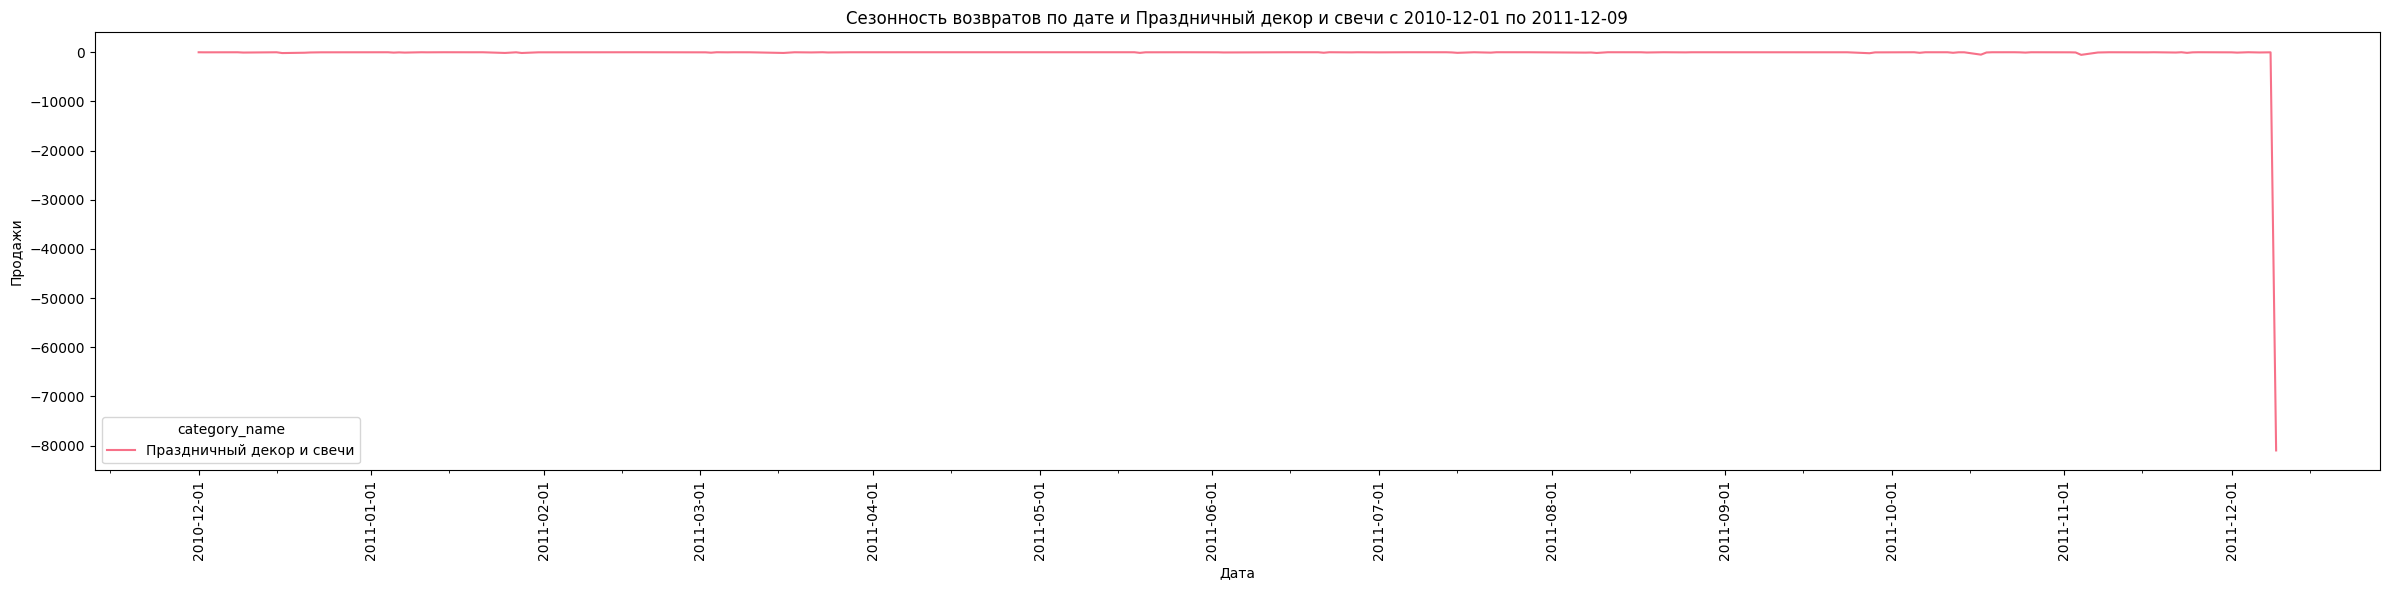

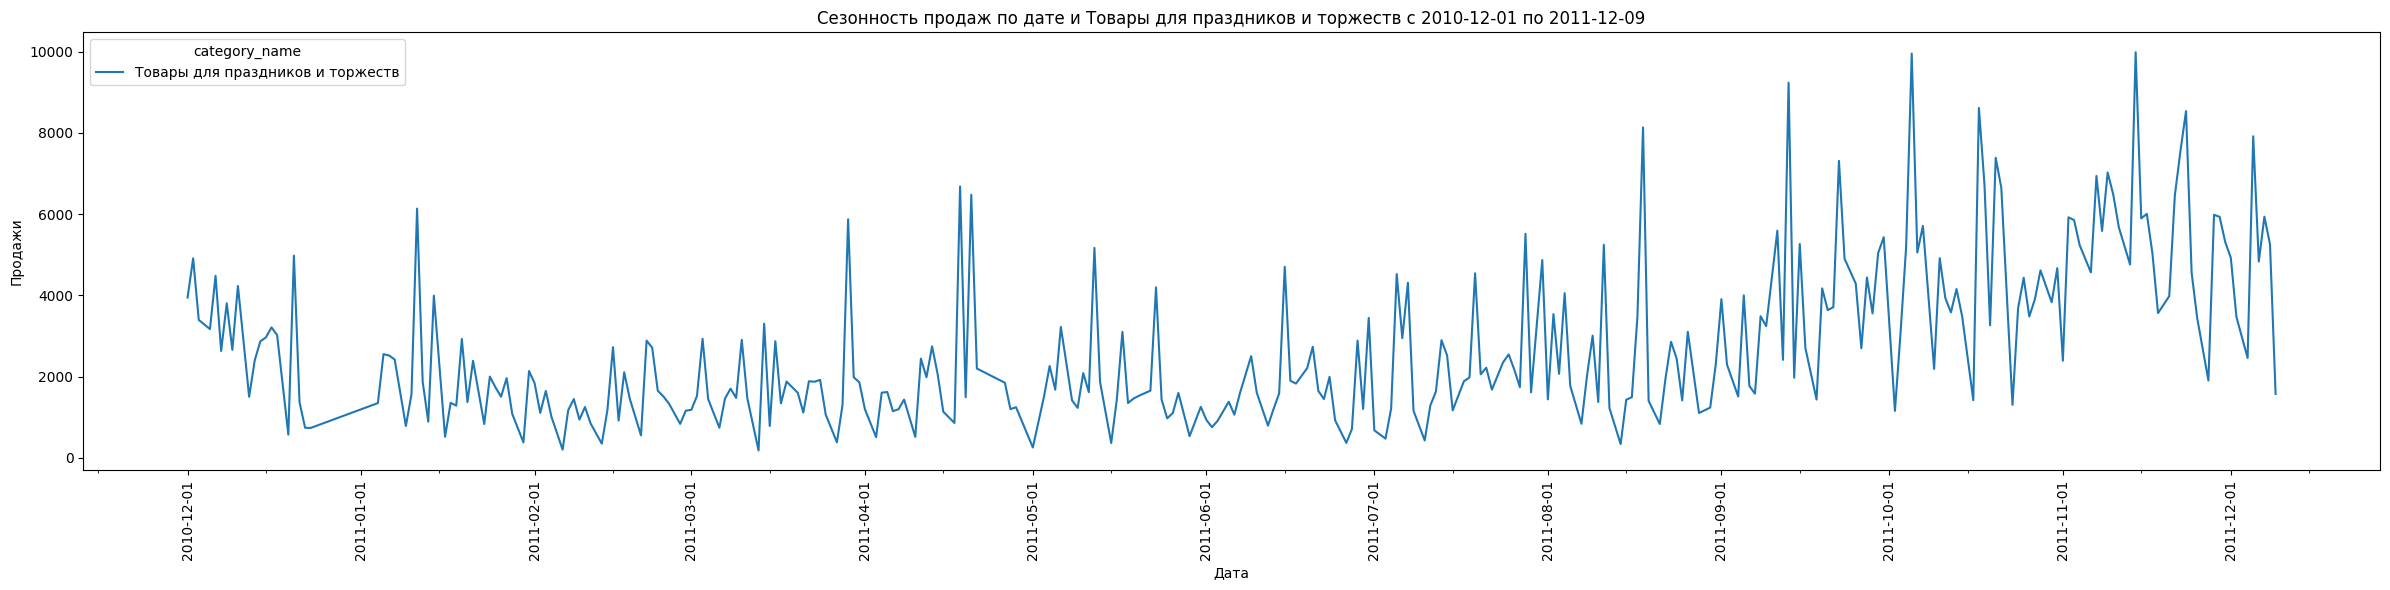

C:\Users\avsip\AppData\Local\Temp\ipykernel_30568\2817455719.py:42: UserWarning: The palette list has more values (9) than needed (1), which may not be intended.
  sns.lineplot(x='Дата', y='Quantity', hue='category_name', data=sales_by_date_cluster, ax=ax, palette=sns.color_palette("husl", 9))


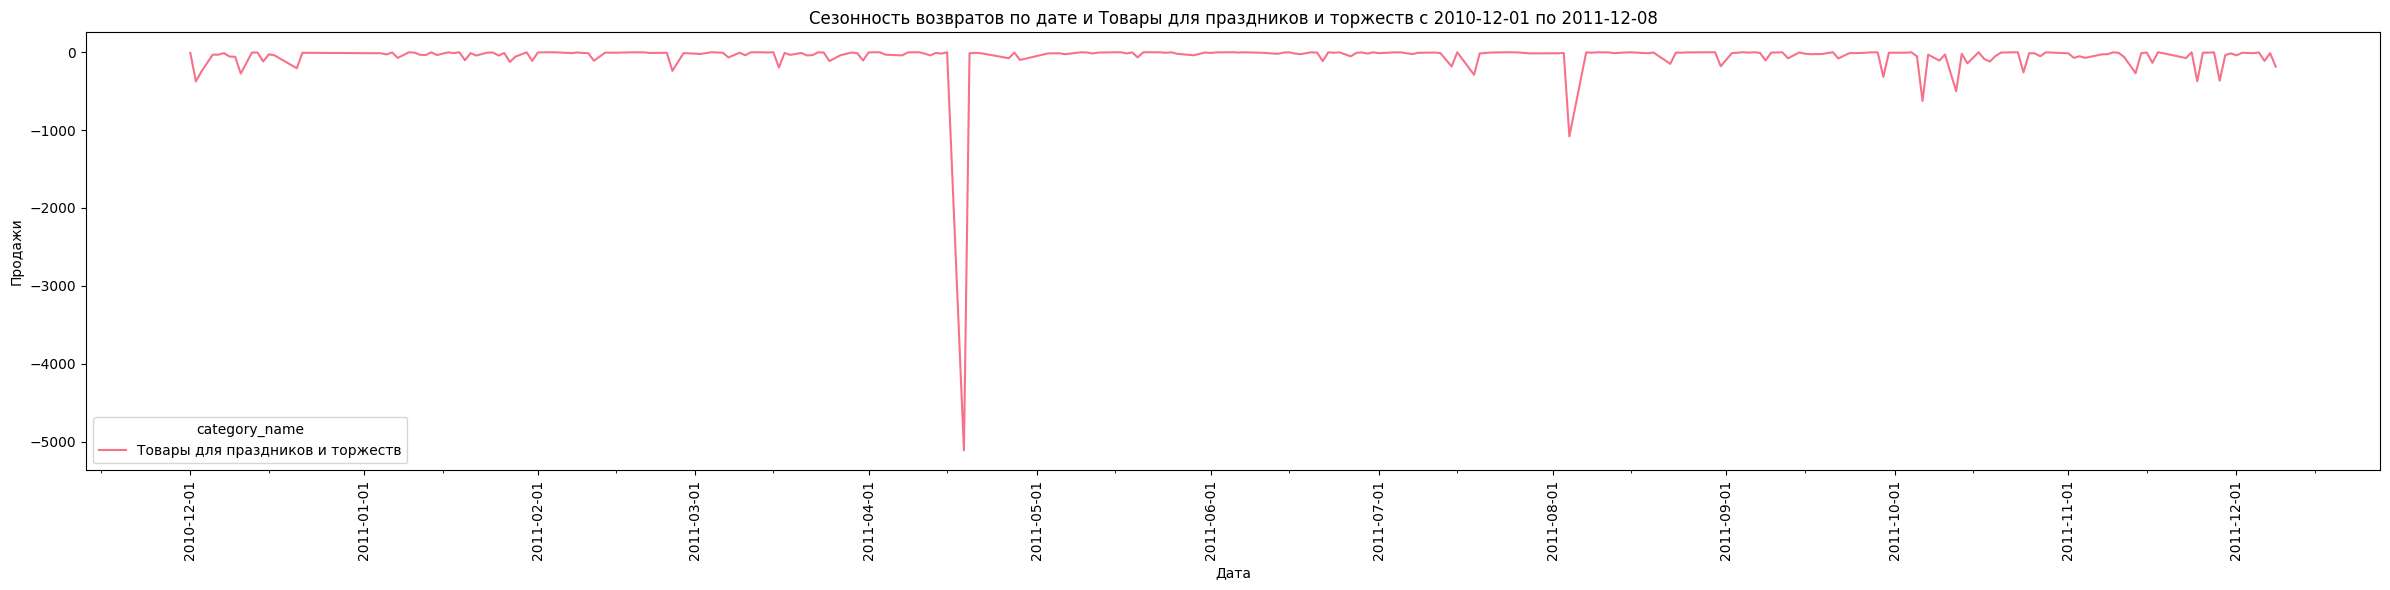

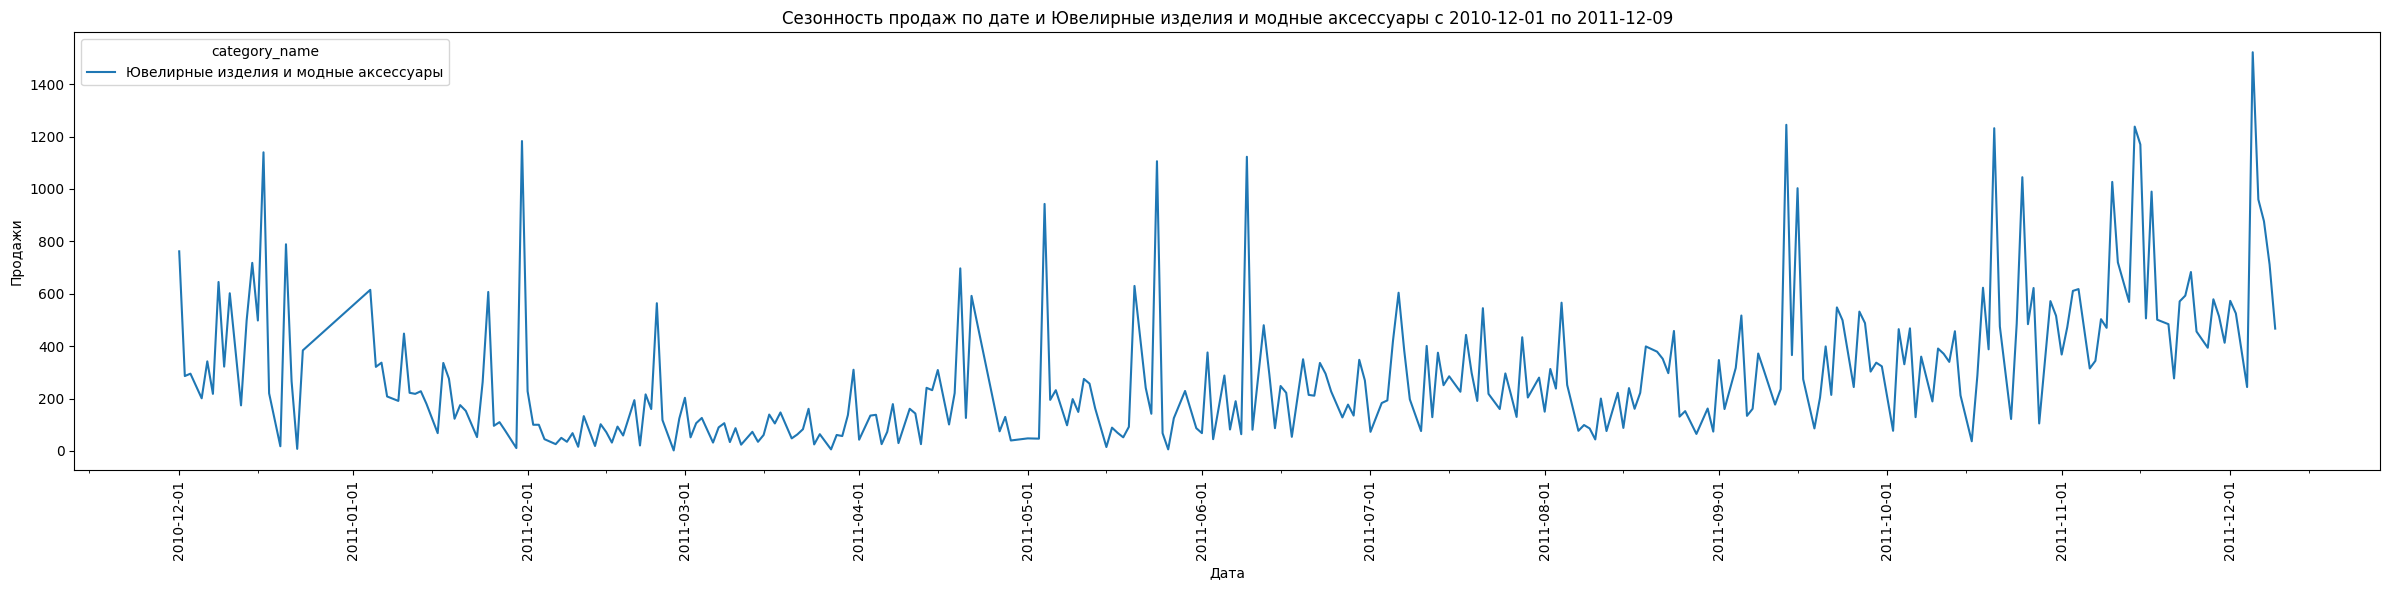

C:\Users\avsip\AppData\Local\Temp\ipykernel_30568\2817455719.py:42: UserWarning: The palette list has more values (9) than needed (1), which may not be intended.
  sns.lineplot(x='Дата', y='Quantity', hue='category_name', data=sales_by_date_cluster, ax=ax, palette=sns.color_palette("husl", 9))


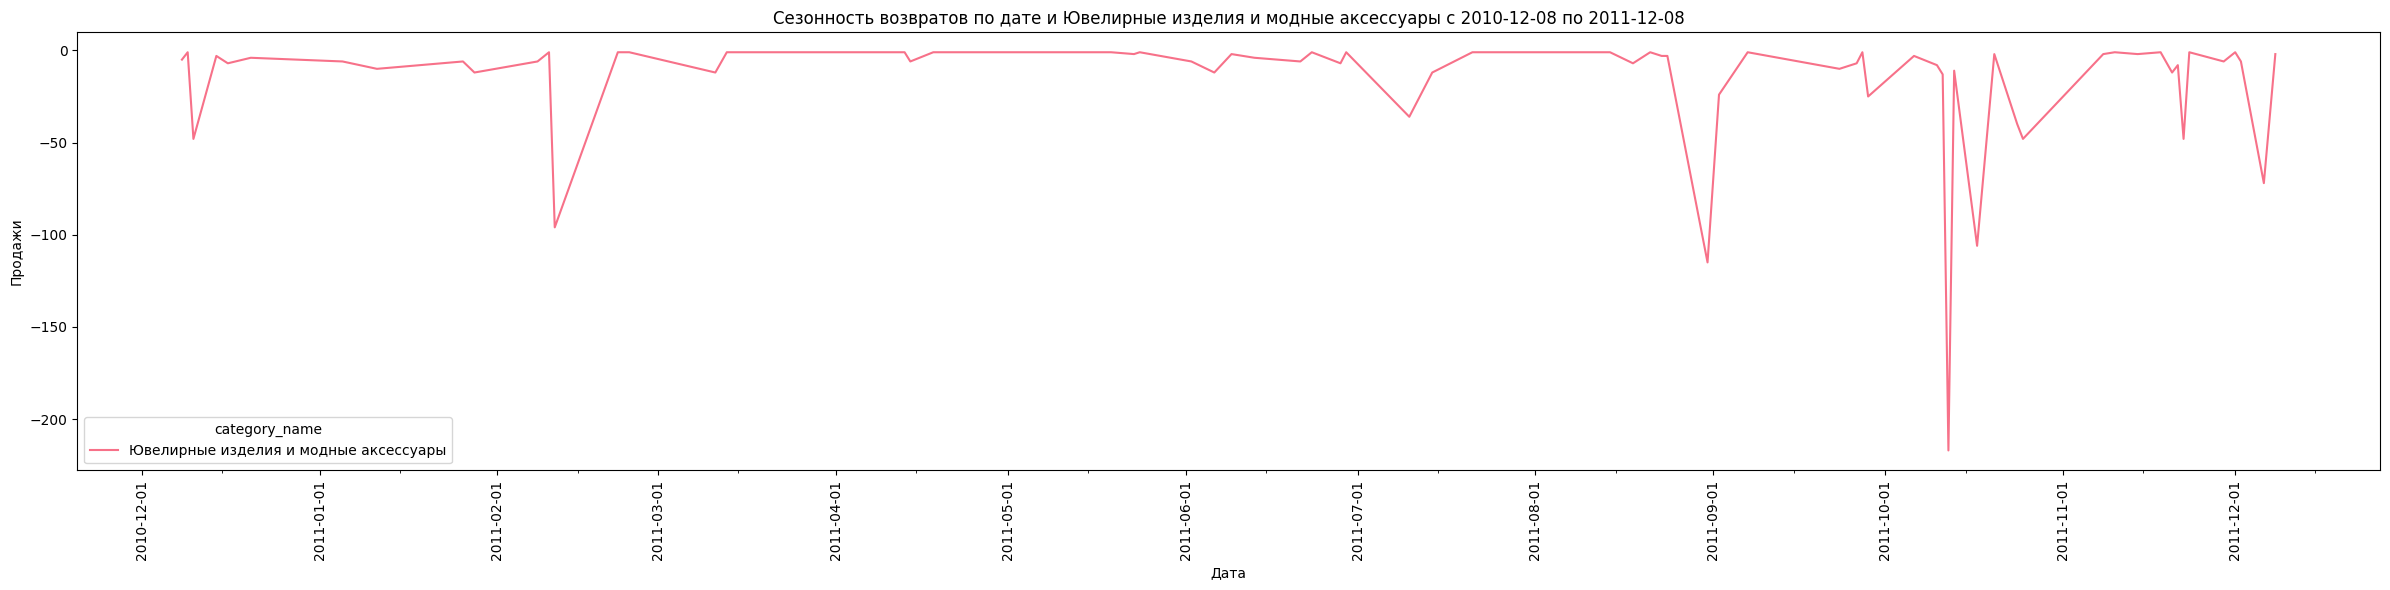

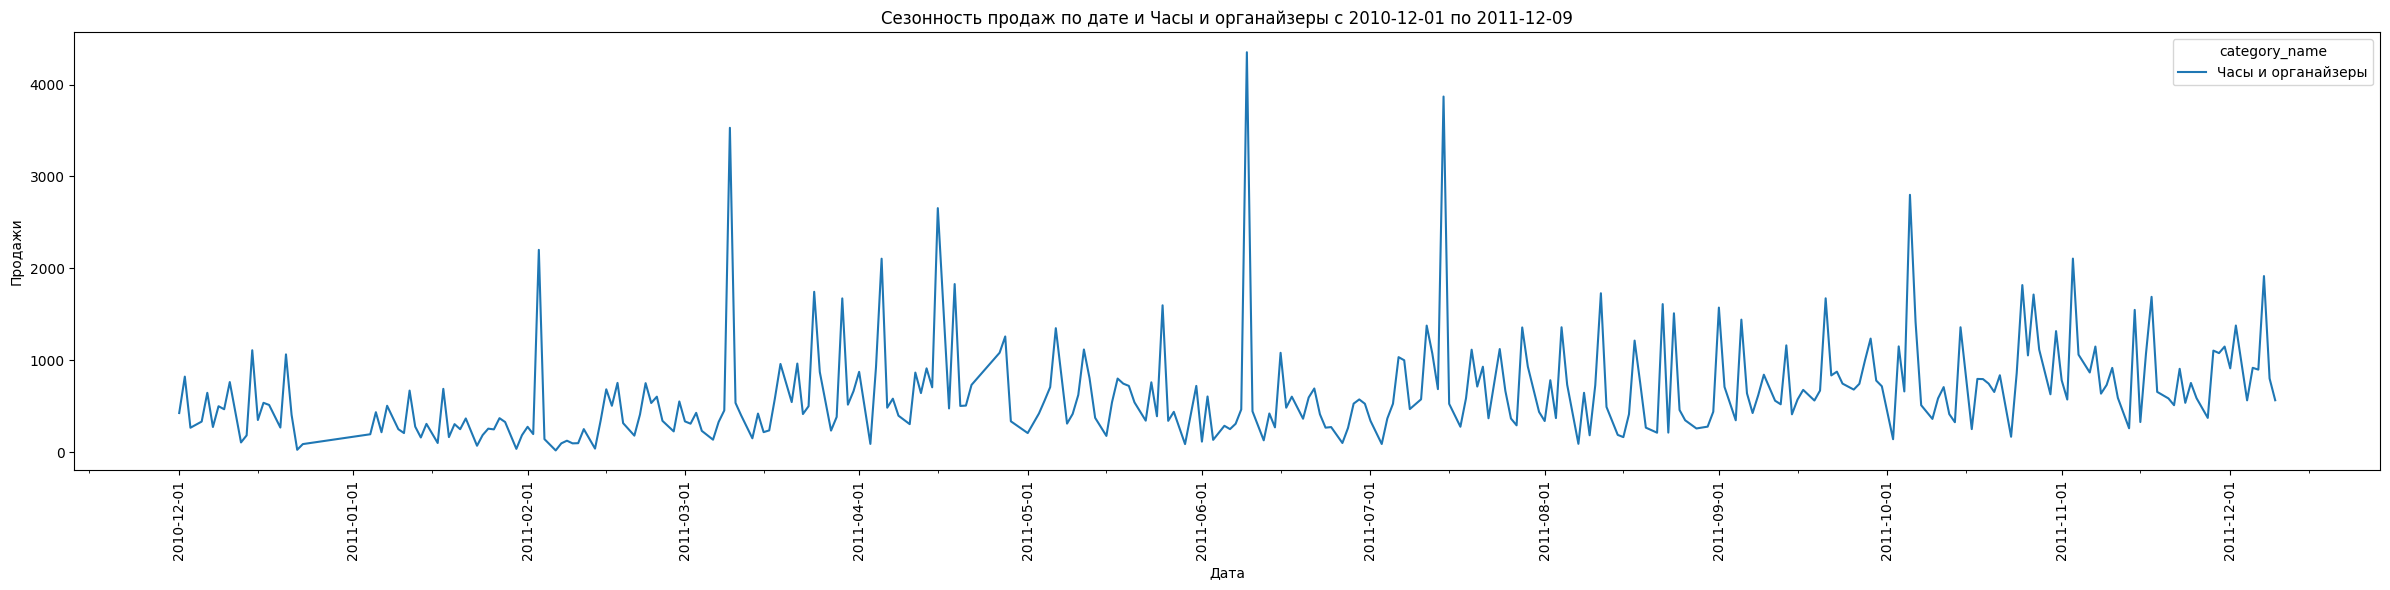

C:\Users\avsip\AppData\Local\Temp\ipykernel_30568\2817455719.py:42: UserWarning: The palette list has more values (9) than needed (1), which may not be intended.
  sns.lineplot(x='Дата', y='Quantity', hue='category_name', data=sales_by_date_cluster, ax=ax, palette=sns.color_palette("husl", 9))


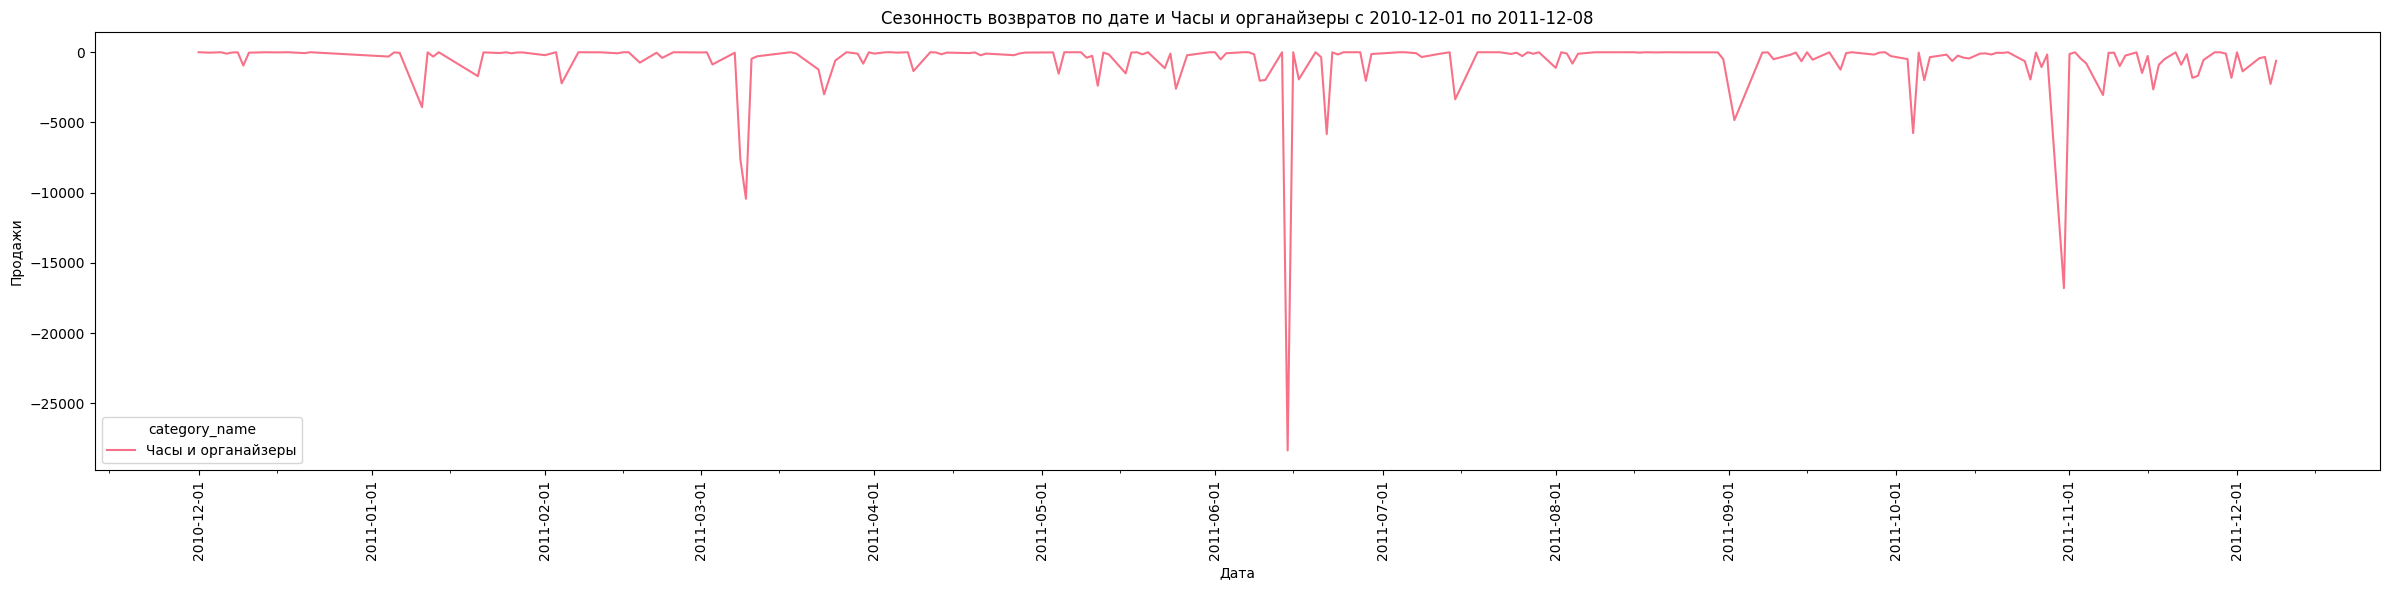

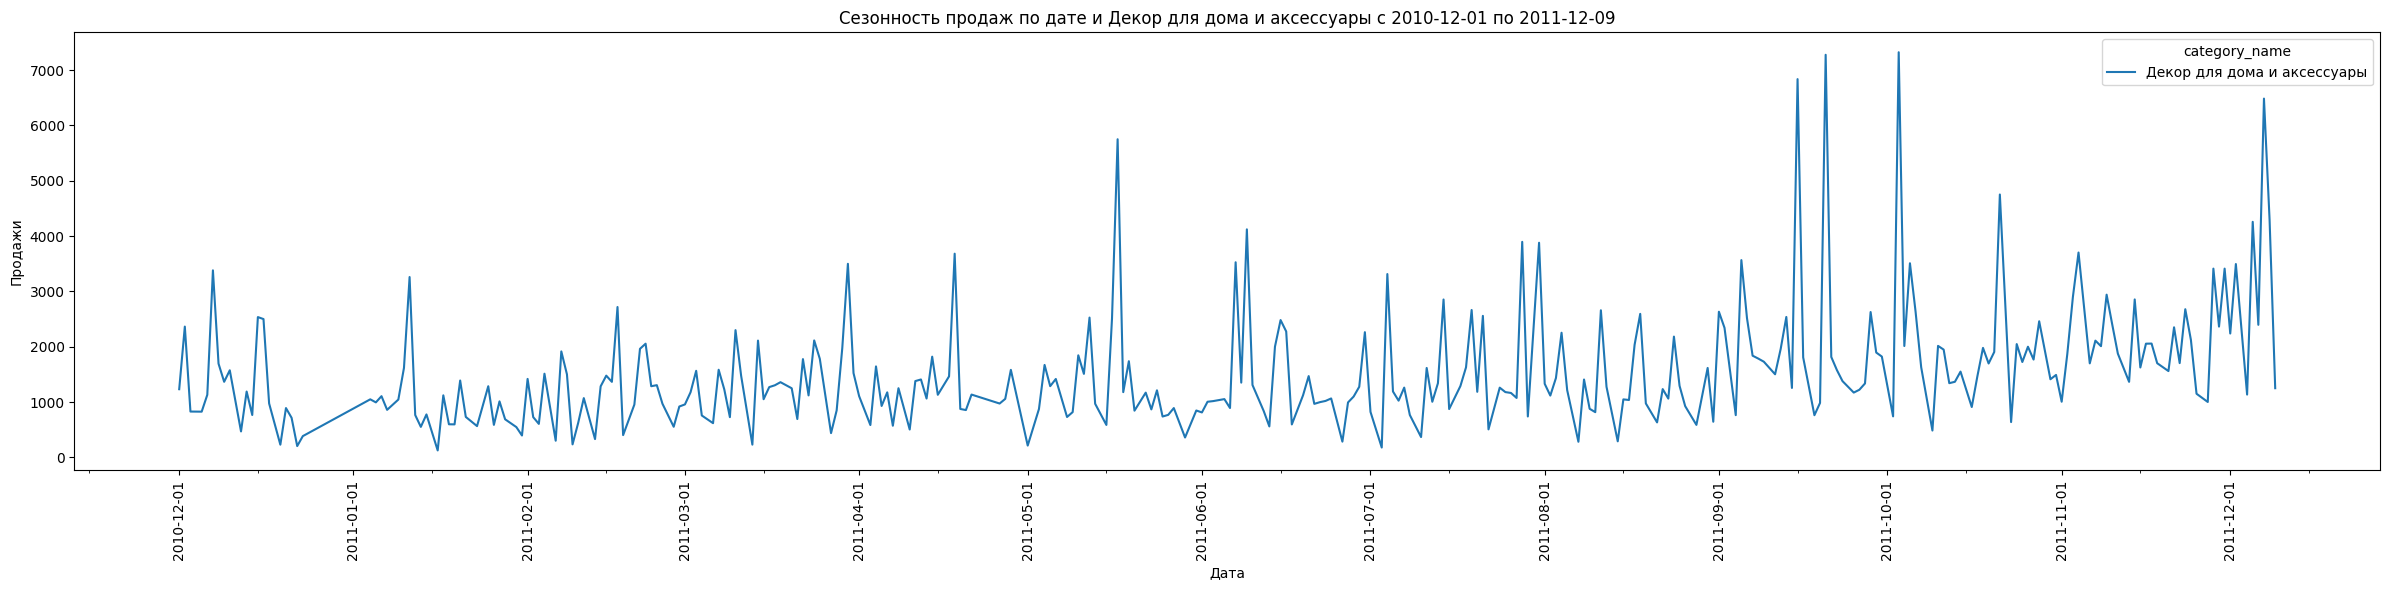

C:\Users\avsip\AppData\Local\Temp\ipykernel_30568\2817455719.py:42: UserWarning: The palette list has more values (9) than needed (1), which may not be intended.
  sns.lineplot(x='Дата', y='Quantity', hue='category_name', data=sales_by_date_cluster, ax=ax, palette=sns.color_palette("husl", 9))


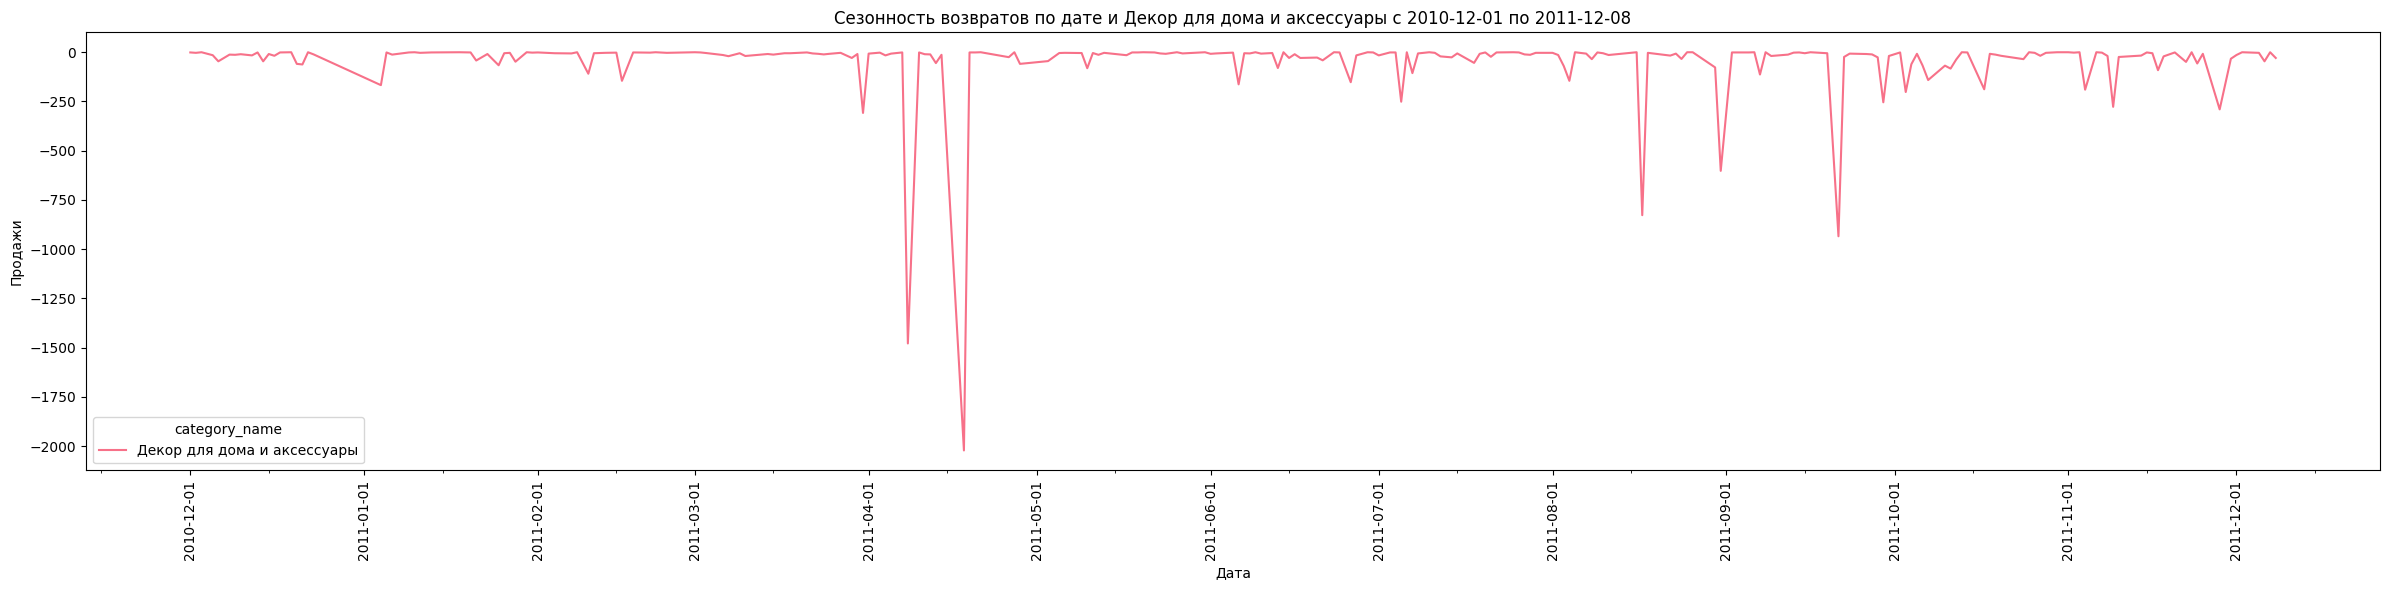

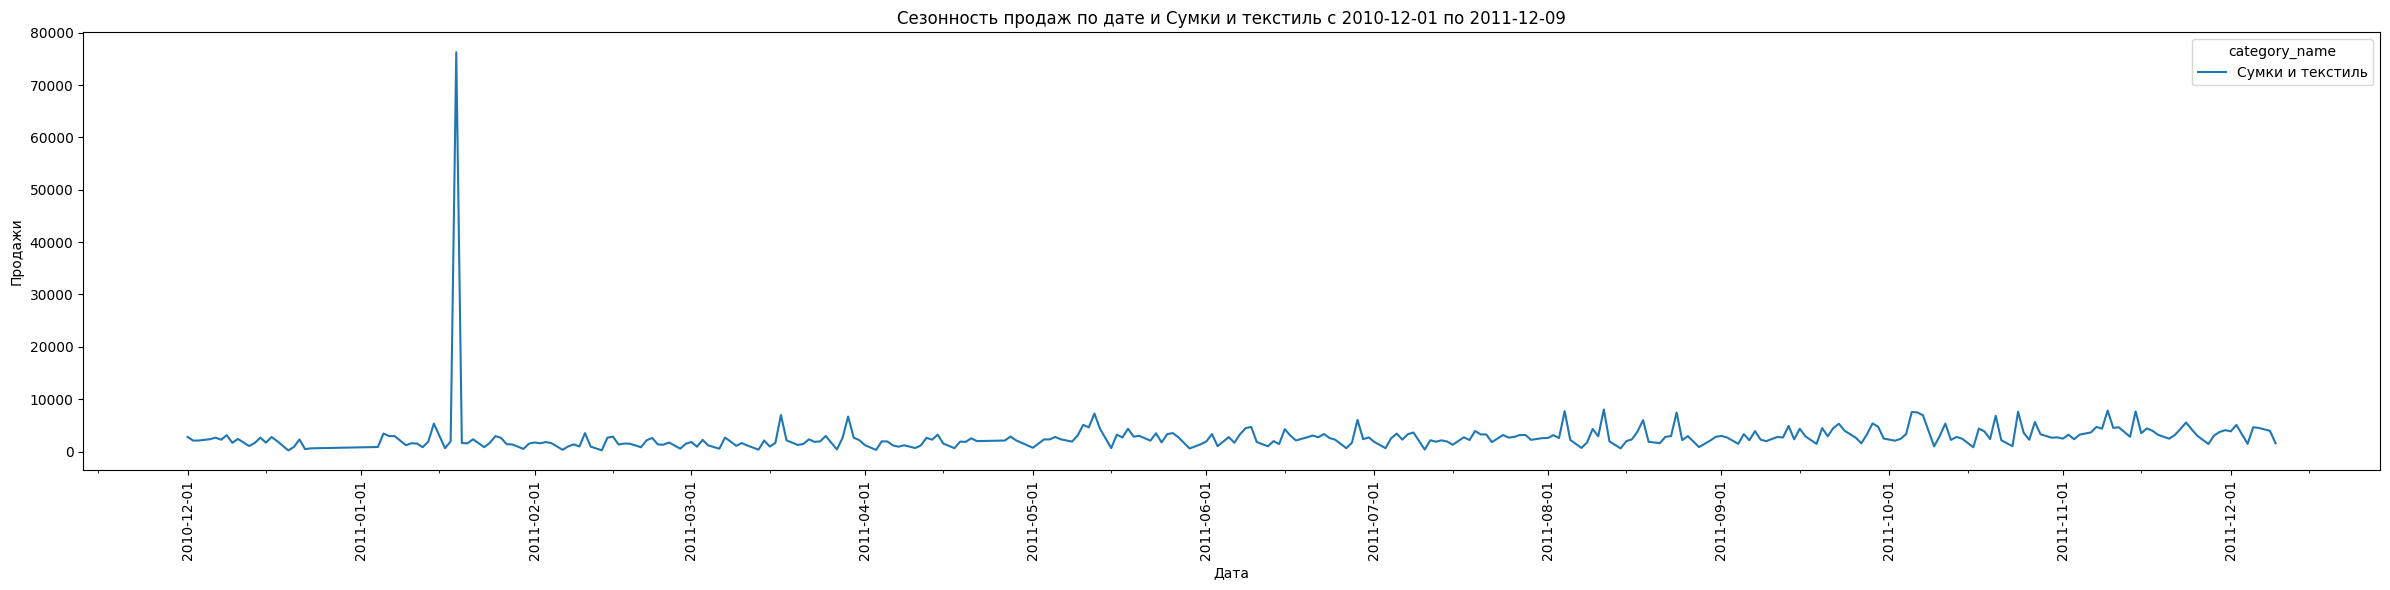

C:\Users\avsip\AppData\Local\Temp\ipykernel_30568\2817455719.py:42: UserWarning: The palette list has more values (9) than needed (1), which may not be intended.
  sns.lineplot(x='Дата', y='Quantity', hue='category_name', data=sales_by_date_cluster, ax=ax, palette=sns.color_palette("husl", 9))


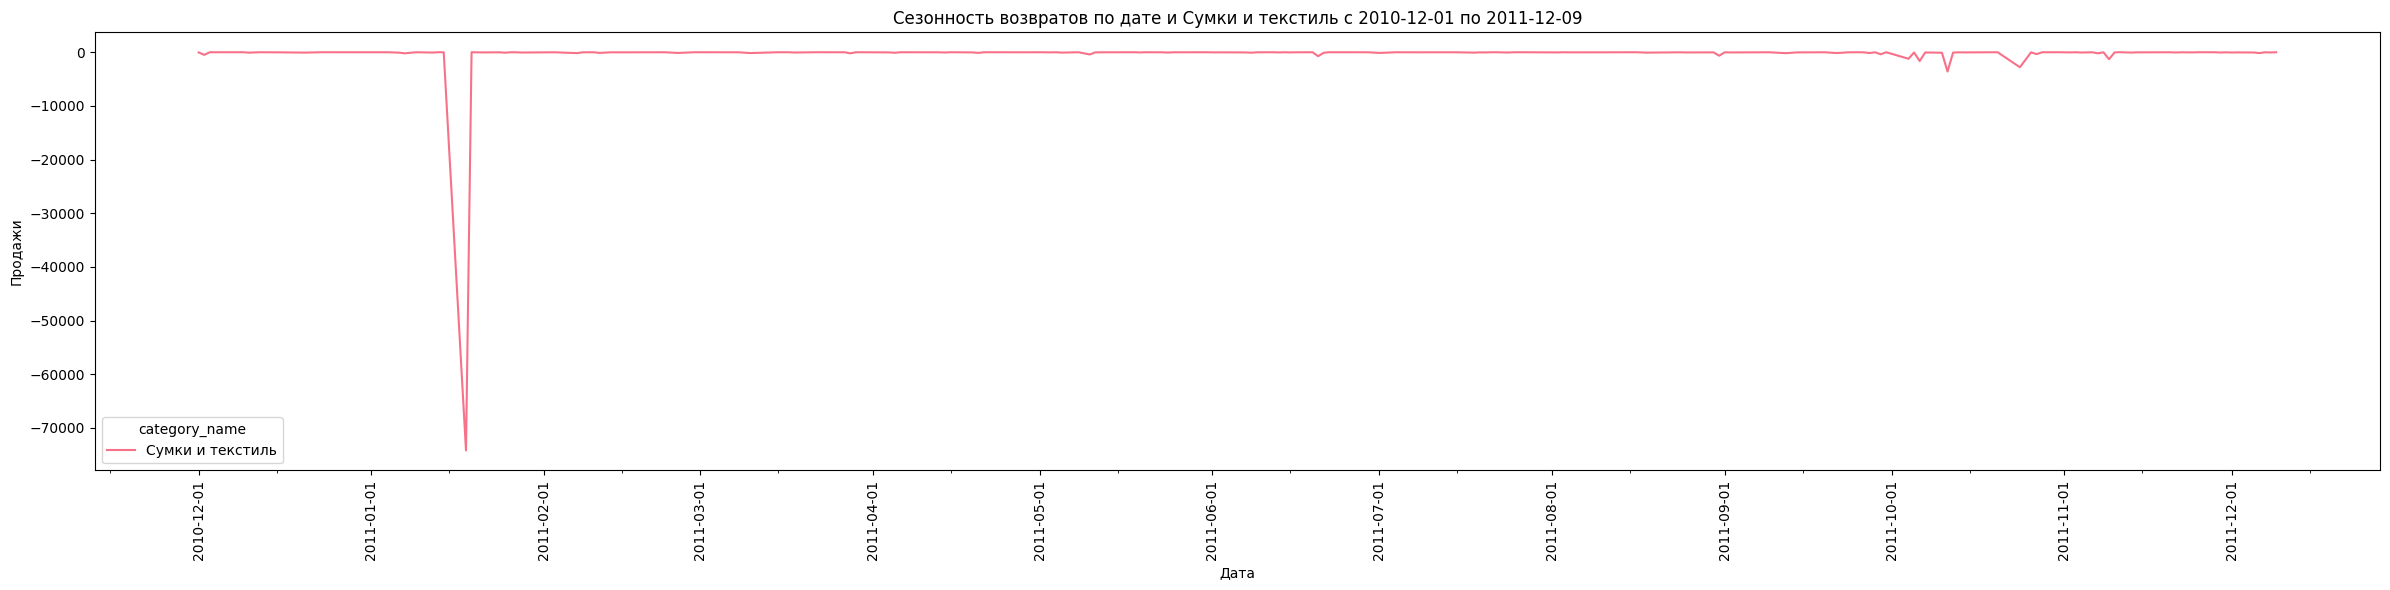

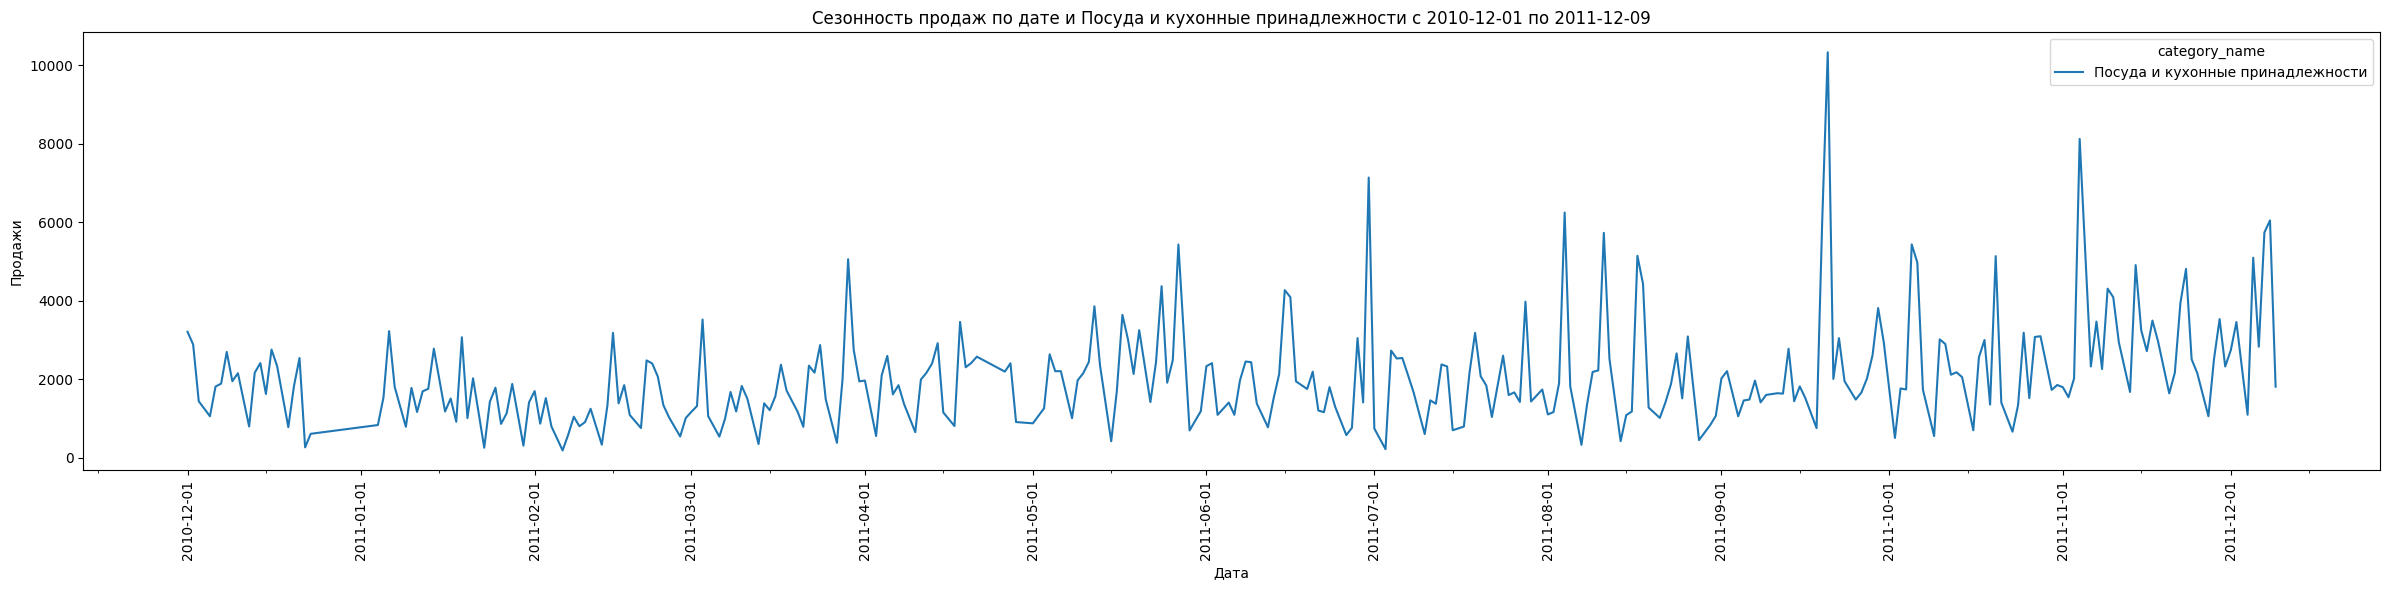

C:\Users\avsip\AppData\Local\Temp\ipykernel_30568\2817455719.py:42: UserWarning: The palette list has more values (9) than needed (1), which may not be intended.
  sns.lineplot(x='Дата', y='Quantity', hue='category_name', data=sales_by_date_cluster, ax=ax, palette=sns.color_palette("husl", 9))


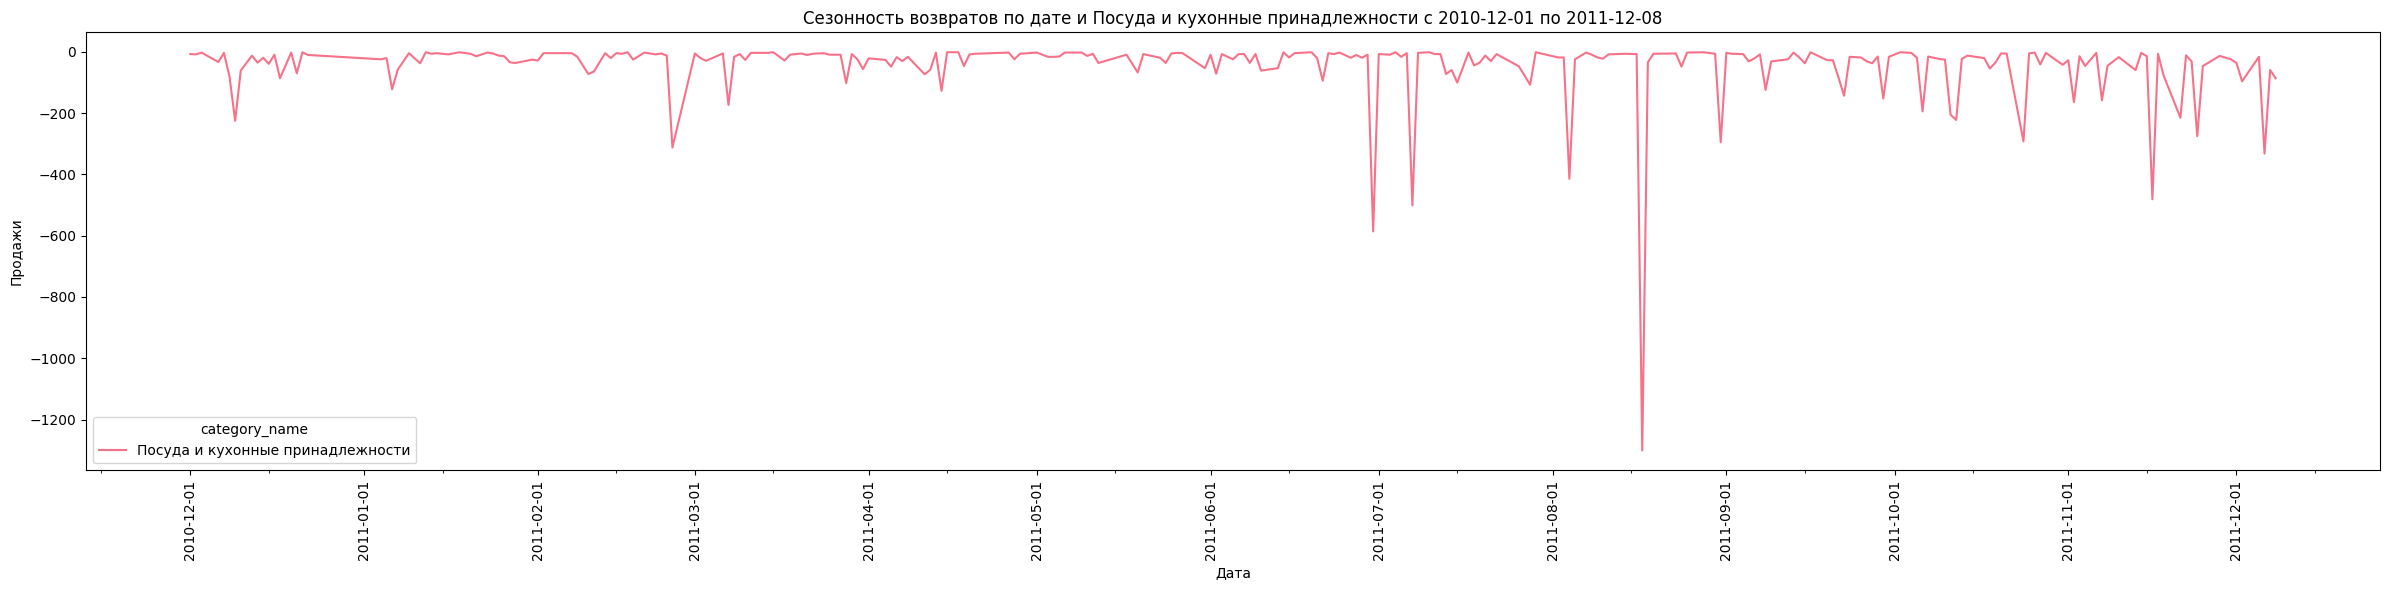

In [228]:
for cat in df_with_category_wtih_out_other['category_name'].unique():
    if type(cat) == str:
        show_graf(cat)
        show_graf_remove(cat)

# первичный анализ датасета
1. есть данные по возвратам
2. данные по названию товаров не выделены в группы
3. доля прочих клиентов не имеющих ID велика
4. каждая транзакция разбита отдельно по товарам в 1 покупке
5. есть отрицательные или 0 суммы в продажах они соответствуют возвратам
6. важно учитывать локацию продаж, так как наблюдается явная доля одной локации

Идеи и гипотезы:
1. всех пользователей которые без ID выделить в прочие, возможно или это недочеты датасета или прочие (иные каналы сбыта)
2. выделить долю транзакций в которых были сделаны возвраты (['все товары в заказе', 'частичный возврат'])
3. добавить фичи, выходные дни, дни недели, месяц, для возможности смены масштаба
4. доработать кластеризацию товаров, и выделить в них топ категорий для анализа или выделить топ категорий по сумме продаж, в разрезе каждой локации
5. после этого, делать более глубокий анализ сезонности продаж
6. далее делать прогноз продаж а так же долю возвратов
7. отдельно можно выделить частоту совершения транзакций для тех покупателей у которых есть ID, для учета данного прогноза в случае увеличения доли потребителей, может оказаться что покупатели совершают не регулярные покупки




выявить корреляцию между категориями товаров, влияющие на совместные покупки (1. совместное наличие товарных запасов 2. совместное позиционирование на витринах)
использовать GPT для катетеризации, далее использовать модель (соблюсти баланс между категориями, чтобы не было пересечения категорий)
другой моделью доразметить категории


///
Список хороших llm моделей с чатами, где можно будет попробовать разметку на категории для топ встречаемых товаров:
https://chat.openai.com/
https://gemini.google.com/app
https://www.perplexity.ai/?login-source=oneTapHome
https://claude.ai/new



## использованные инструменты
использовал разные модели и походы
для ускорения применялись `cuda` 
models = [
    'paraphrase-MiniLM-L6-v2',
    'all-MiniLM-L6-v2',
    'bert-base-uncased',
    'roberta-base',
    'distilbert-base-uncased'
]

при этом на основании лучших показателей лучшей показала себя 
Best model: paraphrase-MiniLM-L6-v2
Best number of clusters (K): 10
Best Silhouette Score: 0.08173604309558868

в итоге получилось 10 кластеров
[первые 30 вывел в файл](./clusters_4_top_20_per_cluster.txt)

на основании данный разметки сформировал [файл](./unique_descriptions_category.xlsx) для оценки качества 
так же сделан перевод `ru`


с перевел некоторые позиций из кластеров на русский для оценки качества, при этом используя gatGPT придал смысл данным категориям

Безусловно есть смежность категорий и они близко расположены друг другу, думаю это обусловлено товарными позициями магазина, и замысловатостью названий категорий

так же попросил GPT разметить первые 1000 позиций по категориям, но не применял данную разметку для дообучения модели. по сути можно применить его разметку к остальным товарам.


построение графиков продаж и возвратов по каждой категории